## Libraries

In [1]:
import pandas as pd
import numpy as np
import os 
import time 
import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew, kurtosis, shapiro, normaltest
from typing import Optional, Dict, Any, Tuple, List
from IPython.display import display, Markdown
from scipy import stats
import optuna
import polars as pl
import gc
import lightgbm as lgb
from scipy.stats import spearmanr, ttest_ind
import joblib
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

## EDA Functions

In [2]:
def describe_dataset(df: pd.DataFrame):
    """
    Overview of a DataFrame, including
    dimensions, memory usage, data types, and detailed descriptive statistics.

    Args:
        df (pd.DataFrame): The input DataFrame to describe.
    """
    
    display(Markdown("## 📋 Dataset Overview"))
    print("--- Basic Dimensions & Memory ---")
    
    # shape
    num_rows, num_cols = df.shape
    print(f"**Shape (Rows, Columns):** ({num_rows:,}, {num_cols:,})")
    
    # memory
    mem_usage = df.memory_usage(deep=True).sum()
    mem_gbs = mem_usage / (1024**2)
    print(f"**Total Memory Usage:** {mem_gbs:.2f} MB")
    
    print("\n--- Feature Data Types and Counts ---")
    
    # data types
    dtype_counts = df.dtypes.astype(str).value_counts().reset_index()
    dtype_counts.columns = ['Data_Type', 'Count']
    print(dtype_counts.to_markdown(index=False))

    
    # stats
    display(Markdown("\n## 📊 Descriptive Statistics"))
    
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime']).columns.tolist()

    # numerical
    if numerical_cols:
        display(Markdown("### Numerical Features"))
        # Use transpose for better readability when many features exist
        num_desc = df[numerical_cols].describe().T
        # Add IQR for a more detailed statistical view
        num_desc['IQR'] = num_desc['75%'] - num_desc['25%']
        display(num_desc.style.format("{:,.2f}"))
        print(f"Found {len(numerical_cols)} numerical features.")

    # categorical
    if categorical_cols:
        display(Markdown("### Categorical / Object Features"))
        # Include top, frequency, and unique count
        cat_desc = df[categorical_cols].describe().T
        display(cat_desc.style.format({"unique": "{:,}", "freq": "{:,}"}))
        print(f"Found {len(categorical_cols)} categorical/object features.")

    # datetime
    if datetime_cols:
        display(Markdown("### Datetime Features"))
        dt_desc = df[datetime_cols].describe().T
        display(dt_desc)
        print(f"Found {len(datetime_cols)} datetime features.")


def missing_duplicates_analysis(df: pd.DataFrame, top_n: int = 20) -> pd.DataFrame:
    print("--- 📊 Missing Data and Duplicates Analysis ---")
    # missing summary
    missing_counts = df.isnull().sum()
    missing_summary = pd.DataFrame({
        'Missing_Count': missing_counts,
        'Missing_Percent': 100 * missing_counts / len(df)
    })
    missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]
    missing_summary = missing_summary.sort_values(by='Missing_Count', ascending=False)
    
    
    # check for duplicates
    num_duplicates = df.duplicated().sum()
    print(f"**Duplicate rows found:** {df.duplicated().sum()}")
    
    # visualisation
    if missing_summary.empty:
        print("✅ **No missing values found** in the dataset.")
        return pd.DataFrame()
    
    print(f"\n**Total features with missing values:** {len(missing_summary)}")
    
    # Select the top n features
    plot_data = missing_summary.head(top_n)
    
    plt.style.use('ggplot')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=plot_data.index,
        y='Missing_Count',
        data=plot_data,
        palette='viridis'
    )
    
    # Add percentage labels above the bars
    for i, count in enumerate(plot_data['Missing_Count']):
        percent = plot_data['Missing_Percent'].iloc[i]
        plt.text(
            x=i, 
            y=count + (df.shape[0] * 0.005),
            s=f'{percent:.1f}%',
            ha='center',
            fontsize=9
        )
    
    plt.title(f"Top {min(top_n, len(missing_summary))} Features by Missing Values Count (Total Rows: {len(df)})", 
              fontsize=14, fontweight='bold')
    plt.xlabel("Feature Name", fontsize=12)
    plt.ylabel("Missing Count", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    print("\n**Missing Data Summary Table (Top 10):**")
    print(missing_summary.head(10).to_markdown(floatfmt=".2f"))
    return missing_summary


def detect_outliers(df, method='iqr', threshold=2.5, z_threshold=3.0, cols=None, summary=True):

    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if method not in ['iqr', 'zscore']:
        raise ValueError("method must be 'iqr' or 'zscore'")

    outlier_flags = pd.DataFrame(False, index=df.index, columns=cols)

    for col in cols:
        series = df[col].dropna()

        if method == 'iqr':
            Q1 = series.quantile(0.25)
            Q3 = series.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            outlier_flags[col] = (df[col] < lower_bound) | (df[col] > upper_bound)

        elif method == 'zscore':
            z_scores = np.abs(stats.zscore(series))
            outlier_flags[col] = z_scores > z_threshold

    if summary:
        summary_df = pd.DataFrame({
            'outlier_count': outlier_flags.sum(),
            'percent_outliers': 100 * outlier_flags.sum() / len(df)
        }).sort_values('percent_outliers', ascending=False)

        print("📊 Outlier Detection Summary:")
        print(summary_df.round(2))
        return outlier_flags, summary_df

    return outlier_flags


def analyze_numeric_distribution(df, variables=None, sample_size=300000):
    """
    Produces distribution plots and statistical diagnostics for numeric variables.
    Includes skewness, kurtosis, normality tests, and interpretation.

    Parameters:
        df : pandas DataFrame
        variables : list of columns to analyze (if None, auto-detect numerics)
        sample_size : subsample for normality tests

    Returns:
        summary_df : DataFrame with skewness, kurtosis, normality results, insights
    """
    
    # Identify numeric variables
    if variables is None:
        variables = df.select_dtypes(include=[np.number]).columns.tolist()
    
    insights = []

    for col in variables:
        data = df[col].dropna()

        # Safety sample for Shapiro test
        sample = data.sample(min(len(data), sample_size), random_state=42)

        # Compute statistics
        col_skew = skew(data)
        col_kurt = kurtosis(data)
        
        # Normality test (D’Agostino & Pearson, fallback to Shapiro)
        try:
            stat, p_normal = normaltest(sample)
        except:
            stat, p_normal = shapiro(sample)

        # Plot distribution
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(data, kde=True, bins=30, color="steelblue")
        plt.title(f"Distribution of {col}")

        plt.subplot(1, 2, 2)
        sns.boxplot(x=data, color="salmon")
        plt.title(f"Boxplot of {col}")

        plt.tight_layout()
        plt.show()

        # Interpretation block
        interpretation = []

        # Skewness interpretation
        if col_skew > 1:
            interpretation.append("Strong right-skew → long right tail, potential outliers. Consider log-transform.")
        elif 0.5 < col_skew <= 1:
            interpretation.append("Moderate right-skew → may benefit from mild transformation.")
        elif -1 <= col_skew < -0.5:
            interpretation.append("Moderate left-skew → data clusters toward high values.")
        elif col_skew < -1:
            interpretation.append("Strong left-skew → long left tail, possible lower-bound saturation.")
        else:
            interpretation.append("Approximately symmetric distribution.")

        # Kurtosis interpretation
        if col_kurt > 3:
            interpretation.append("High kurtosis → heavy tails, many outliers (leptokurtic).")
        elif col_kurt < -1:
            interpretation.append("Very flat distribution → potential multimodality (platykurtic).")
        else:
            interpretation.append("Reasonable kurtosis → no extreme tail behavior.")

        # Normality insight
        if p_normal < 0.05:
            interpretation.append("Normality test FAILED → distribution is not normal.")
        else:
            interpretation.append("Normality test PASSED → distribution may be approximately normal.")

        # Transformation suggestion
        if col_skew > 0.75:
            interpretation.append("Suggested transform: log(x + 1) or Box-Cox.")
        elif col_skew < -0.75:
            interpretation.append("Suggested transform: reflect + log, or Winsorization.")
        
        insights.append({
            "variable": col,
            "skewness": col_skew,
            "kurtosis": col_kurt,
            "normality_p_value": p_normal,
            "insights": " | ".join(interpretation),
        })

    return pd.DataFrame(insights)

def plot_correlation_matrix(df):
    # Compute correlation matrix
    df = df[df.select_dtypes(include=[np.number]).columns.tolist()]
    corr_matrix = df.corr()

    # Create a mask to hide the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))

    # Plot heatmap with the mask
    sns.heatmap(corr_matrix, mask=mask, annot=True,
                cmap="coolwarm", fmt=".2f", linewidths=0.5)

    # Title
    plt.title("Feature Correlation Heatmap")
    plt.show()



def plot_categorical_distribution(df, column, top_n=15, figsize=(10, 5)):
    """
    Plots the percentage distribution of a categorical variable.
    
    Parameters:
        df      : DataFrame
        column  : str, categorical column to plot
        top_n   : int, number of most frequent categories to display
        figsize : tuple, size of the plot
    """

    # Drop missing values
    data = df[column].dropna()

    # Value counts normalized (percentage)
    perc = (data.value_counts(normalize=True) * 100).sort_values(ascending=False)

    # Restrict to top_n categories (to avoid clutter)
    if len(perc) > top_n:
        perc = perc.head(top_n)

    plt.figure(figsize=figsize)
    ax = sns.barplot(x=perc.index, y=perc.values, palette="viridis")

    # Add percentages above bars
    for i, v in enumerate(perc.values):
        ax.text(i, v + 0.5, f"{v:.1f}%", ha="center", fontsize=10)

    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Percentage (%)")
    plt.title(f"Percentage Distribution of '{column}'")
    plt.tight_layout()
    plt.show()


def plot_binary_feature(df, column, figsize=(6,4)):
    """
    Plots the percentage distribution of a binary feature (0/1 or True/False).
    """
    # Normalize to percentages
    counts = df[column].value_counts(normalize=True) * 100
    counts = counts.sort_index()  # ensure 0 then 1 order
    
    plt.figure(figsize=figsize)
    sns.barplot(x=counts.index.astype(str), y=counts.values, palette=["#4C72B0", "#55A868"])
    
    for i, v in enumerate(counts.values):
        plt.text(i, v + 1, f"{v:.1f}%", ha="center", fontsize=11)
    
    plt.title(f"Binary Feature Distribution: {column}")
    plt.xlabel(f"{column} (0/1)")
    plt.ylabel("Percentage (%)")
    plt.ylim(0, 110)
    plt.tight_layout()
    plt.show()


def numeric_vs_target(df, feature, target, figsize=(10,5)):
    """
    Visualize how a numeric feature differs between target=0 and target=1.
    Includes KDE distribution, boxplot, mean difference, and effect size.
    """

    plt.figure(figsize=figsize)

    # ---------- KDE DISTRIBUTION ----------
    sns.kdeplot(data=df, x=feature, hue=target, fill=True, common_norm=False,
                palette=["#4C72B0", "#DD8452"], alpha=0.5)
    plt.title(f"Distribution of {feature} by {target}")
    plt.show()

    # ---------- BOX PLOT ----------
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x=target, y=feature, palette="Set2")
    plt.title(f"Boxplot of {feature} by {target}")
    plt.show()

    # ---------- STATISTICS ----------
    group0 = df[df[target] == 0][feature].dropna()
    group1 = df[df[target] == 1][feature].dropna()

    mean_diff = group1.mean() - group0.mean()
    pooled_std = np.sqrt((group0.var() + group1.var()) / 2)
    cohend = mean_diff / pooled_std

    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)

    print(f"\n📌 **Stats for {feature} vs {target}:**")
    print(f"Mean (No Diabetes): {group0.mean():.2f}")
    print(f"Mean (Diabetes):    {group1.mean():.2f}")
    print(f"Mean Difference:    {mean_diff:.2f}")
    print(f"Cohen's d:          {cohend:.3f}  → {'SMALL' if abs(cohend)<0.3 else 'MEDIUM' if abs(cohend)<0.8 else 'LARGE'} effect")
    print(f"T-test p-value:     {p_val:.3e}\n")


def categorical_vs_target(df, feature, target, normalize=True, figsize=(10,5)):
    """
    Plot diabetes prevalence across categories of a categorical feature.
    """

    # Compute percentages
    proportions = (
        df.groupby(feature)[target]
          .mean()
          .sort_values(ascending=False)
          .reset_index()
    )
    
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        data=proportions,
        x=feature,
        y=target,
        palette="viridis"
    )
    
    # Add text labels
    for i, v in enumerate(proportions[target]):
        ax.text(i, v + 0.01, f"{v*100:.1f}%", ha="center", fontsize=10)
    
    plt.title(f"Diabetes Prevalence by {feature}")
    plt.ylabel("Diabetes Rate")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    print(proportions)


def binary_vs_target(df, col, target):
    """
    Analyze the relationship between a binary feature (0/1) and a binary target.
    Produce a table + barplot with annotated event rates.
    
    Parameters
    ----------
    df : pd.DataFrame
    col : str
        Name of binary feature column (must contain values 0/1)
    target : str
        Name of binary target column
    """

    # --- Validate input -------------------------------------------------------
    if df[col].nunique() > 2:
        raise ValueError(f"Column {col} is not binary.")
    if df[target].nunique() > 2:
        raise ValueError(f"Target {target} must be binary.")
    
    # --- Compute outcome rate per group ---------------------------------------
    summary = (
        df.groupby(col)[target]
        .agg(
            count="count",
            positives="sum",
            mean_rate="mean"
        )
        .reset_index()
    )
    
    summary["mean_rate_pct"] = summary["mean_rate"] * 100

    # Optional: compute comparison metrics
    if set(summary[col]) == {0,1}:
        p0 = summary.loc[summary[col] == 0, "mean_rate"].values[0]
        p1 = summary.loc[summary[col] == 1, "mean_rate"].values[0]

        summary["risk_ratio"] = p1 / p0 if p0 > 0 else None
        summary["delta_rate"] = p1 - p0
    else:
        summary["risk_ratio"] = None
        summary["delta_rate"] = None

    # --- Plot ---------------------------------------------------------------
    plt.figure(figsize=(8,5))
    sns.barplot(
        data=summary,
        x=col,
        y="mean_rate_pct",
        palette="Blues_r"
    )

    # Annotate bars
    for idx, row in summary.iterrows():
        plt.text(
            idx,
            row["mean_rate_pct"] + 0.5,
            f"{row['mean_rate_pct']:.1f}%",
            ha="center",
            fontsize=12,
            fontweight="bold"
        )

    plt.title(f"{col} vs {target} (Outcome Rate Comparison)", fontsize=14)
    plt.xlabel(col)
    plt.ylabel(f"% {target}=1")
    plt.tight_layout()
    plt.show()

    return summary



def engineer_features(df):
    daily_physical_hours = (df["physical_activity_minutes_per_week"] / 60) / 7

    df["screen_activity_ratio"] = df["screen_time_hours_per_day"] / (daily_physical_hours + 1e-6)
    df["sleep_efficiency_pct"] = df["sleep_hours_per_day"] / (24 - df["screen_time_hours_per_day"] - (daily_physical_hours + 1e-6))                                                                  
    df["pulse_pressure"] = df["systolic_bp"] - df["diastolic_bp"]
    df["pulse_pressure_ratio"] = (df["pulse_pressure"] / df["systolic_bp"])
    df["mean_arterial_pressure"] = (df["systolic_bp"] + 2 * df["diastolic_bp"]) / 3
    df["rate_pressure_product"] = df["heart_rate"] * df["systolic_bp"]
    df["ldl_hdl_ratio"] = df["ldl_cholesterol"] / (df["hdl_cholesterol"] + 1e-9)
    df["cholesterol_hdl_ratio"] = df["cholesterol_total"] / (df["hdl_cholesterol"] + 1e-9)
    df["non_hdl_cholesterol"] = df["cholesterol_total"] - df["hdl_cholesterol"]
    df["ldl_cholesterol_share"] = df["ldl_cholesterol"] / (df["cholesterol_total"] + 1e-9)
    df["tg_hdl_ratio"] = df["triglycerides"] / (df["hdl_cholesterol"] + 1e-9)
    df["age_bmi_risk"] = df["age"] * df["bmi"]
    df["age_norm_activity"] = df["physical_activity_minutes_per_week"] / (df["age"] + 1)
    df["activity_bmi_diff"] = df["physical_activity_minutes_per_week"] - df["bmi"]
    df["screen_activity_ratio"] = df["screen_time_hours_per_day"] / ((df["physical_activity_minutes_per_week"] / 60) / 7 + 1e-6)

    df['risk_history'] = df['hypertension_history'] + df['cardiovascular_history']
    df['genetic_history'] = df['family_history_diabetes'] * df['bmi']
    df['activity_x_age'] = df['physical_activity_minutes_per_week'] * df['age']
    
    df["lipid_sum"] = df["cholesterol_total"] + df["triglycerides"]
    df["lipid_burden"] = (df["ldl_hdl_ratio"] + df["tg_hdl_ratio"] + df["cholesterol_hdl_ratio"])
    df["age_map_risk"] = df["age"] * df["mean_arterial_pressure"]

    df["lifestyle_risk_score"] = (
        0.3 * df["bmi"] +
        0.2 * df["waist_to_hip_ratio"] +
        0.2 * df["screen_time_hours_per_day"] -
        0.2 * df["physical_activity_minutes_per_week"] -
        0.1 * df["sleep_hours_per_day"]
    )

    return df

def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n===== {name} METRICS =====")
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    print("F1:", f1_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} ROC")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.show()

    # Precision Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(recall, precision, label=f"{name} PR")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{name} - Precision Recall Curve")
    plt.legend()
    plt.show()

def train_cv_model(model_name, model, X, y, n_splits=3):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    oof_pred = np.zeros(len(X))
    fold_scores = []
    fold_models = [] 

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        print(f"\n===== {model_name} - Fold {fold+1} =====")

        X_train, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[valid_idx]

        if model_name == "XGBoost":
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        elif model_name == "CatBoost":
            model.fit(
                X_train, y_train,
                cat_features=CATEGORY_COLUMNS,
                eval_set=(X_val, y_val),
                verbose=False
            )
        else:  # LightGBM
            model.fit(
                X_train, y_train,
                categorical_feature=CATEGORY_COLUMNS,
                eval_set=[(X_val, y_val)]
            )

        # ---- VALIDATION PREDICTIONS ----
        val_pred_proba = model.predict_proba(X_val)[:, 1]
        oof_pred[valid_idx] = val_pred_proba

        # ---- METRICS ----
        fold_auc = roc_auc_score(y_val, val_pred_proba)
        fold_scores.append(fold_auc)
        print(f"Fold ROC-AUC: {fold_auc:.4f}")

        fold_models.append(model)   # SAVE THIS FOLD MODEL

    print(f"\n===== {model_name} CV ROC-AUC: "
          f"{np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f} =====")

    # Return OOF predictions AND the final fold model
    return oof_pred, fold_models[-1]

def get_feature_importance(model, feature_names):
    """
    Returns a pandas DataFrame with feature names and importance scores
    for LightGBM, XGBoost, and CatBoost.
    """
    if hasattr(model, "feature_importances_"):
        # LightGBM / CatBoost
        importance = model.feature_importances_

    elif hasattr(model, "get_booster"):
        # XGBoost (need to access booster)
        booster = model.get_booster()
        importance_dict = booster.get_score(importance_type='gain')
        importance = np.array([importance_dict.get(f"f{i}", 0) for i in range(len(feature_names))])

    else:
        raise ValueError(f"Model type {type(model)} not supported for feature importance.")

    return pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    }).sort_values("importance", ascending=False)

def plot_feature_importance(importance_df, model_name, top_n=20):
    df = importance_df.copy()
    df = df.sort_values("importance", ascending=False).head(top_n)

    plt.figure(figsize=(10, 8))
    sns.barplot(
        data=df,
        x="importance",
        y="feature",
        palette="viridis"
    )
    plt.title(f"Top {top_n} Feature Importances — {model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


def train_all_models(X, y):

    pos_weight = (y == 0).sum() / (y == 1).sum()
    class_weights = {0: 1.0, 1: pos_weight}

    models = {
        "LightGBM": LGBMClassifier(
            n_estimators=11000,
            learning_rate=0.01,
            subsample=0.8,
            num_leaves=128,
            colsample_bytree=0.8,
            device="gpu", 
            eval_metric="auc",
            scale_pos_weight=pos_weight,
            random_state=RANDOM_SEED
        ),
        "XGBoost": XGBClassifier(
            n_estimators=11000,
            learning_rate=0.01,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="auc",
            verbosity=0,  
            tree_method="gpu_hist",
            scale_pos_weight=pos_weight,
            enable_categorical=True,
            random_state=RANDOM_SEED
        ),
        "CatBoost": CatBoostClassifier(
            iterations=11000,
            learning_rate=0.01,
            depth=8,
            task_type="GPU",
            eval_metric="AUC",
            verbose=False,
            random_seed=RANDOM_SEED,
            loss_function="Logloss",
            class_weights=class_weights
        )
    }

    oof_preds = {}
    trained_models = {}
    feature_importances = {}
    
    for name, model in models.items():
        preds, fitted_model = train_cv_model(name, model, X, y)
        oof_preds[name] = preds
        trained_models[name] = fitted_model
        fi = get_feature_importance(fitted_model, X.columns)
        feature_importances[name] = fi

    return oof_preds, trained_models, feature_importances

def evaluate_ensemble(oof_preds, y):
    # Soft voting (average probabilities)
    ensemble_proba = (
        (0.25 * oof_preds["LightGBM"]) +
        (0.30 * oof_preds["XGBoost"]) +
        (0.45 * oof_preds["CatBoost"])
    )

    ensemble_pred = (ensemble_proba >= 0.55).astype(int)

    evaluate_model("Ensemble", y, ensemble_pred, ensemble_proba)


def fit_full_models(models, X, y):
    """Retrain all models on full dataset for test-time predictions."""
    full_trained = {}
    for name, model in models.items():
        print(f"\nTraining full model: {name}")
        
        if name == "CatBoost":
            model.fit(
                X, y,
                cat_features=CATEGORY_COLUMNS,
                verbose=False
            )
        else:
            # LightGBM, XGBoost, etc.
            model.fit(X, y)
        
        full_trained[name] = model
    
    return full_trained

def predict_test(models, X_test):
    preds = {}
    for name, model in models.items():
        preds[name] = model.predict_proba(X_test)[:, 1]   # probability of diabetes = 1
    return preds

def ensemble_predictions(preds_dict):
    import numpy as np
    model_preds = np.column_stack(list(preds_dict.values()))
    final_pred = model_preds.mean(axis=1)  # simple average
    return final_pred

## Config

In [3]:
RANDOM_SEED = 25
NUMERIC_CONTINUOUS = [
    'age',
    'alcohol_consumption_per_week',
    'physical_activity_minutes_per_week',
    'diet_score',
    'sleep_hours_per_day',
    'screen_time_hours_per_day',
    'bmi',
    'waist_to_hip_ratio',
    'systolic_bp',
    'diastolic_bp',
    'heart_rate',
    'cholesterol_total',
    'hdl_cholesterol',
    'ldl_cholesterol',
    'triglycerides'
]

NUMERIC_BINARY = [
    'family_history_diabetes',
    'hypertension_history',
    'cardiovascular_history'
]

NUMERIC_COLUMNS = NUMERIC_CONTINUOUS + NUMERIC_BINARY

CATEGORY_COLUMNS = ['gender', 'ethnicity', 'education_level', 'income_level',
       'smoking_status', 'employment_status']

TARGET = 'diagnosed_diabetes'

MODEL_FEATURES = ['age',
 'alcohol_consumption_per_week',
 'physical_activity_minutes_per_week',
 'diet_score',
 'sleep_hours_per_day',
 'screen_time_hours_per_day',
 'bmi',
 'waist_to_hip_ratio',
 'systolic_bp',
 'diastolic_bp',
 'heart_rate',
 'cholesterol_total',
 'hdl_cholesterol',
 'ldl_cholesterol',
 'triglycerides',
 'family_history_diabetes',
 'hypertension_history',
 'cardiovascular_history',
 'screen_activity_ratio',
 'sleep_efficiency_pct',
 'pulse_pressure',
 'mean_arterial_pressure',
 'rate_pressure_product',
 'ldl_hdl_ratio',
 'cholesterol_hdl_ratio',
 'non_hdl_cholesterol',
 'ldl_cholesterol_share',
 'tg_hdl_ratio',
 'age_bmi_risk',
 'age_norm_activity',
 'activity_bmi_diff',
 'lipid_sum',
 'lifestyle_risk_score',
 'activity_x_age',
 "lipid_burden",
 "pulse_pressure_ratio",
 "age_map_risk",
 'risk_history',
 'genetic_history',
 'gender', 
 'ethnicity', 
 'education_level', 
 'income_level',
 'smoking_status', 
 'employment_status']


In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s5e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e12/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s5e12/sample_submission.csv')

In [5]:
describe_dataset(train)

## 📋 Dataset Overview

--- Basic Dimensions & Memory ---
**Shape (Rows, Columns):** (700,000, 26)
**Total Memory Usage:** 362.93 MB

--- Feature Data Types and Counts ---
| Data_Type   |   Count |
|:------------|--------:|
| int64       |      14 |
| float64     |       6 |
| object      |       6 |



## 📊 Descriptive Statistics

### Numerical Features

,count,mean,std,min,25%,50%,75%,max,IQR
id,"700,000.00","349,999.50","202,072.74",0.00,"174,999.75","349,999.50","524,999.25","699,999.00","349,999.50"
age,"700,000.00",50.36,11.66,19.00,42.00,50.00,58.00,89.00,16.00
alcohol_consumption_per_week,"700,000.00",2.07,1.05,1.00,1.00,2.00,3.00,9.00,2.00
physical_activity_minutes_per_week,"700,000.00",80.23,51.20,1.00,49.00,71.00,96.00,747.00,47.00
diet_score,"700,000.00",5.96,1.46,0.10,5.00,6.00,7.00,9.90,2.00
sleep_hours_per_day,"700,000.00",7.00,0.90,3.10,6.40,7.00,7.60,9.90,1.20
screen_time_hours_per_day,"700,000.00",6.01,2.02,0.60,4.60,6.00,7.40,16.50,2.80
bmi,"700,000.00",25.87,2.86,15.10,23.90,25.90,27.80,38.40,3.90
waist_to_hip_ratio,"700,000.00",0.86,0.04,0.68,0.83,0.86,0.88,1.05,0.05
systolic_bp,"700,000.00",116.29,11.01,91.00,108.00,116.00,124.00,163.00,16.00


Found 20 numerical features.


### Categorical / Object Features

,count,unique,top,freq
gender,700000,3,Female,"363,237"
ethnicity,700000,5,White,"386,153"
education_level,700000,4,Highschool,"344,145"
income_level,700000,5,Middle,"290,557"
smoking_status,700000,3,Never,"494,448"
employment_status,700000,4,Employed,"516,170"


Found 6 categorical/object features.


In [6]:
describe_dataset(test)

## 📋 Dataset Overview

--- Basic Dimensions & Memory ---
**Shape (Rows, Columns):** (300,000, 25)
**Total Memory Usage:** 153.25 MB

--- Feature Data Types and Counts ---
| Data_Type   |   Count |
|:------------|--------:|
| int64       |      14 |
| object      |       6 |
| float64     |       5 |



## 📊 Descriptive Statistics

### Numerical Features

,count,mean,std,min,25%,50%,75%,max,IQR
id,"300,000.00","849,999.50","86,602.68","700,000.00","774,999.75","849,999.50","924,999.25","999,999.00","149,999.50"
age,"300,000.00",50.43,11.94,19.00,42.00,50.00,59.00,89.00,17.00
alcohol_consumption_per_week,"300,000.00",2.09,1.07,1.00,1.00,2.00,3.00,9.00,2.00
physical_activity_minutes_per_week,"300,000.00",92.35,62.19,1.00,51.00,77.00,115.00,748.00,64.00
diet_score,"300,000.00",5.95,1.48,0.10,5.00,6.00,7.00,9.90,2.00
sleep_hours_per_day,"300,000.00",7.00,0.91,3.10,6.40,7.00,7.60,9.90,1.20
screen_time_hours_per_day,"300,000.00",6.01,2.06,0.60,4.60,6.00,7.40,15.90,2.80
bmi,"300,000.00",25.88,2.89,15.10,23.90,25.90,27.80,38.30,3.90
waist_to_hip_ratio,"300,000.00",0.86,0.04,0.69,0.83,0.86,0.89,1.05,0.06
systolic_bp,"300,000.00",116.37,11.25,91.00,108.00,116.00,124.00,170.00,16.00


Found 19 numerical features.


### Categorical / Object Features

,count,unique,top,freq
gender,300000,3,Female,"154,098"
ethnicity,300000,5,White,"168,375"
education_level,300000,4,Highschool,"153,355"
income_level,300000,5,Middle,"124,249"
smoking_status,300000,3,Never,"211,666"
employment_status,300000,4,Employed,"217,993"


Found 6 categorical/object features.


The distribution seems realistic so that 20% of adults show higher levels of hypertension.

In [7]:
# detect_outliers(train)

## Analyze Numeric Continuous Features

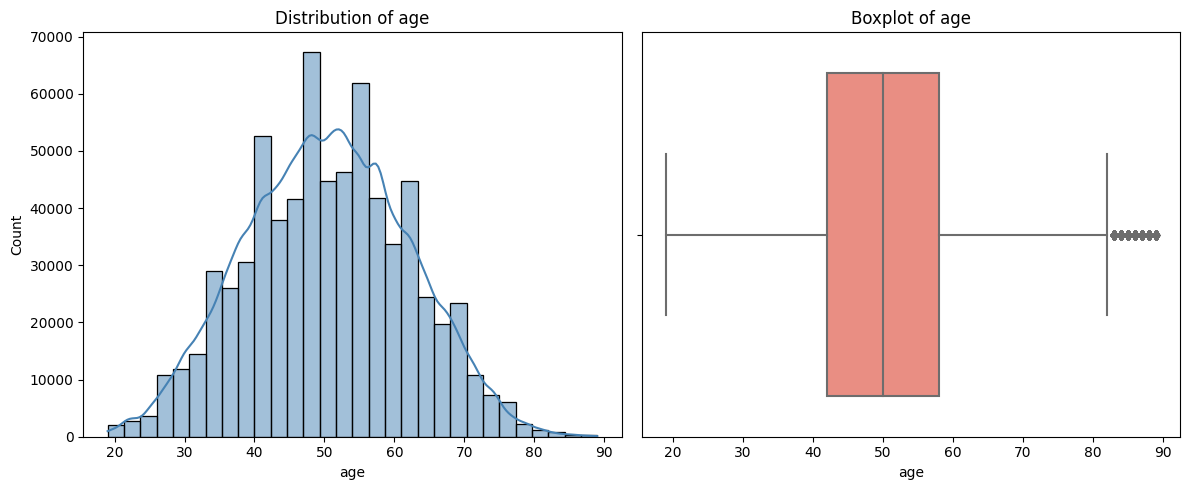

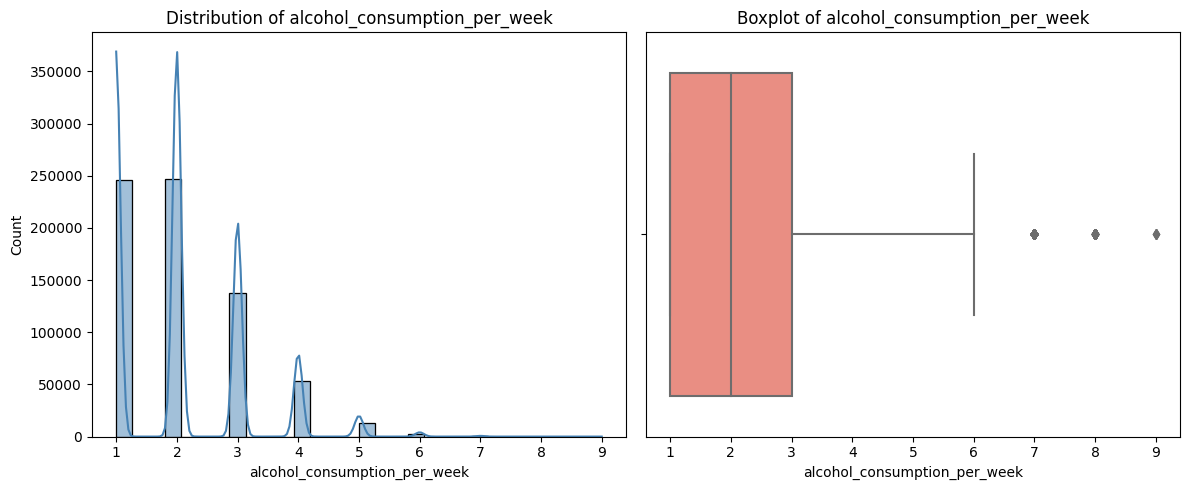

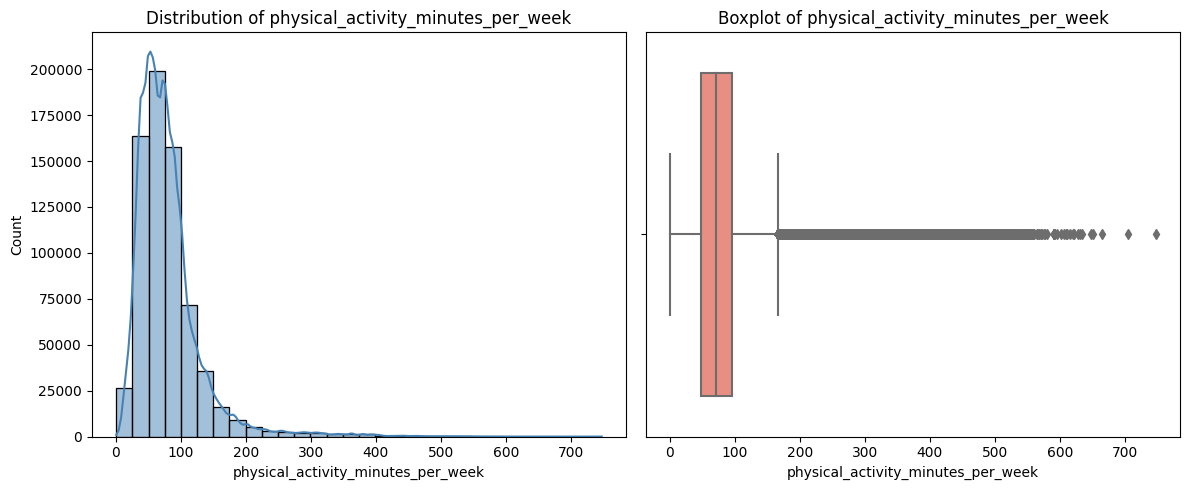

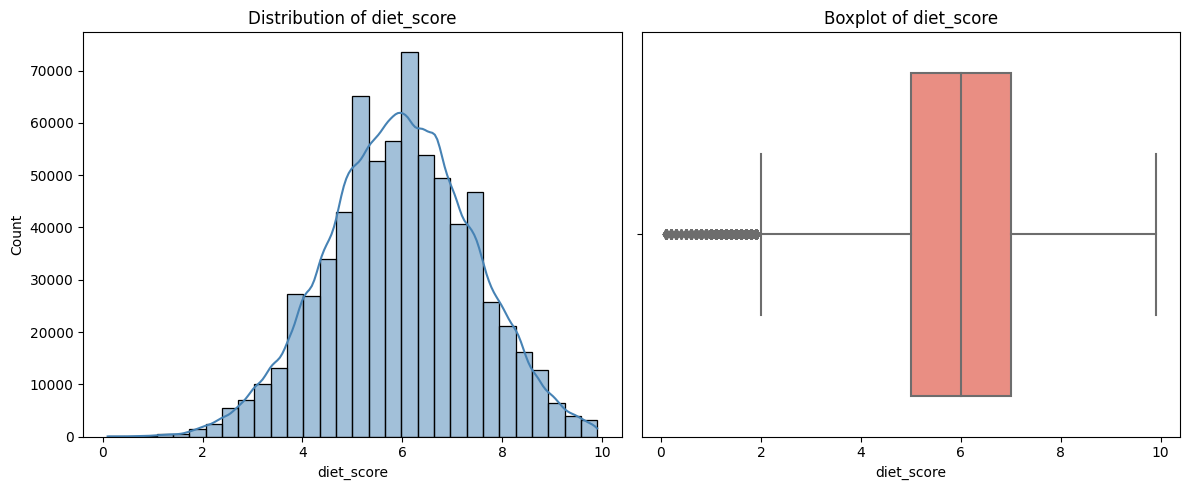

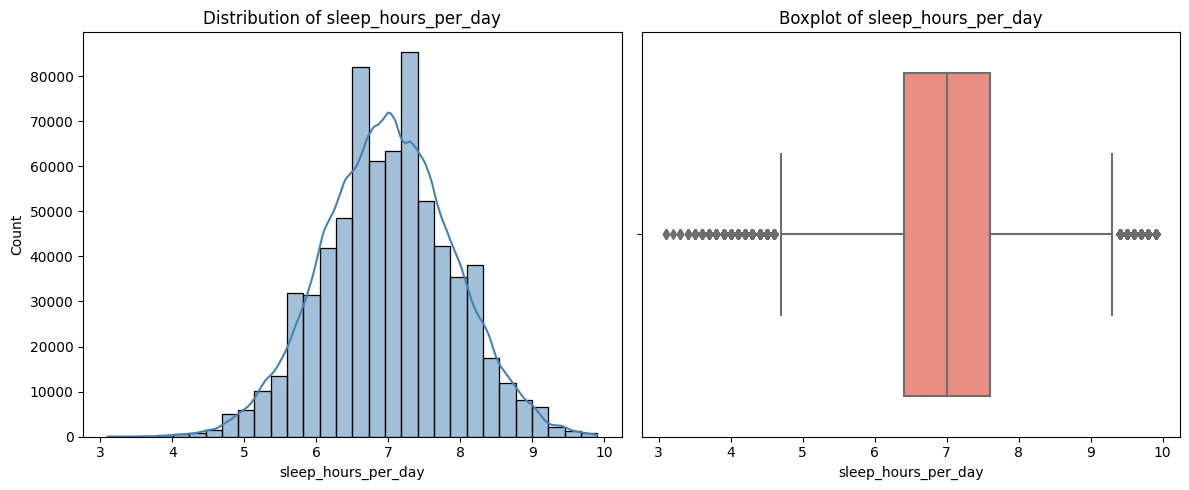

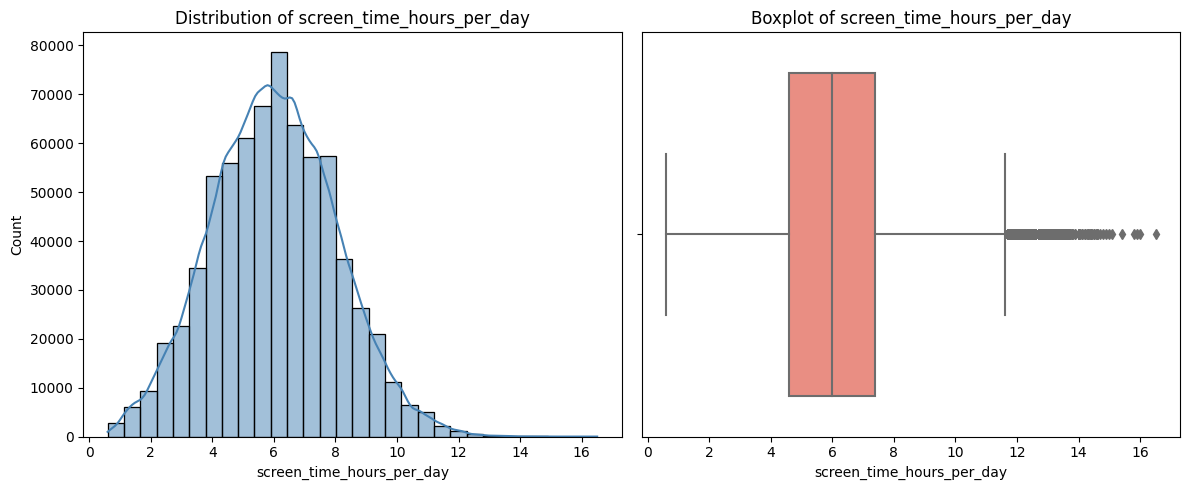

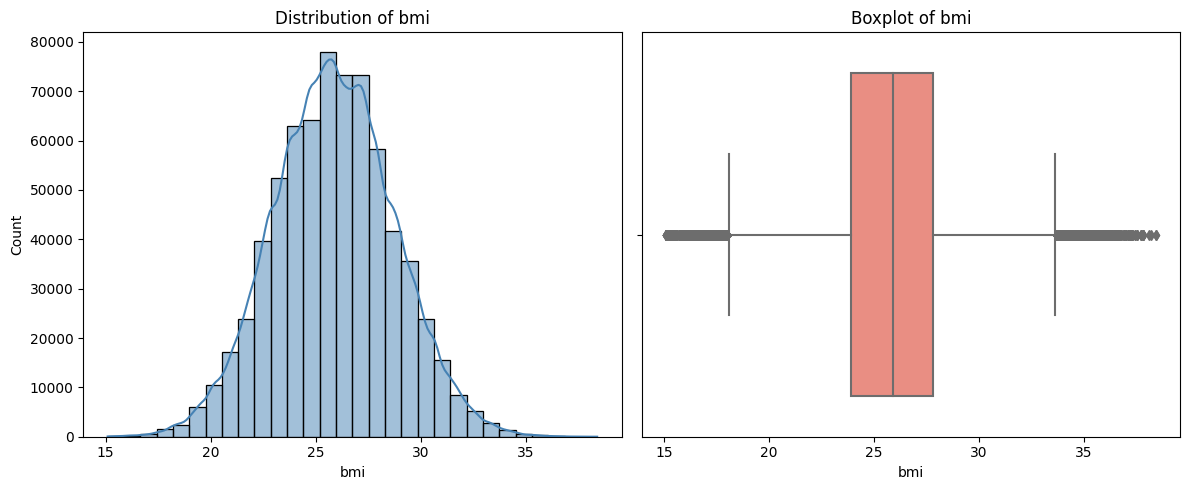

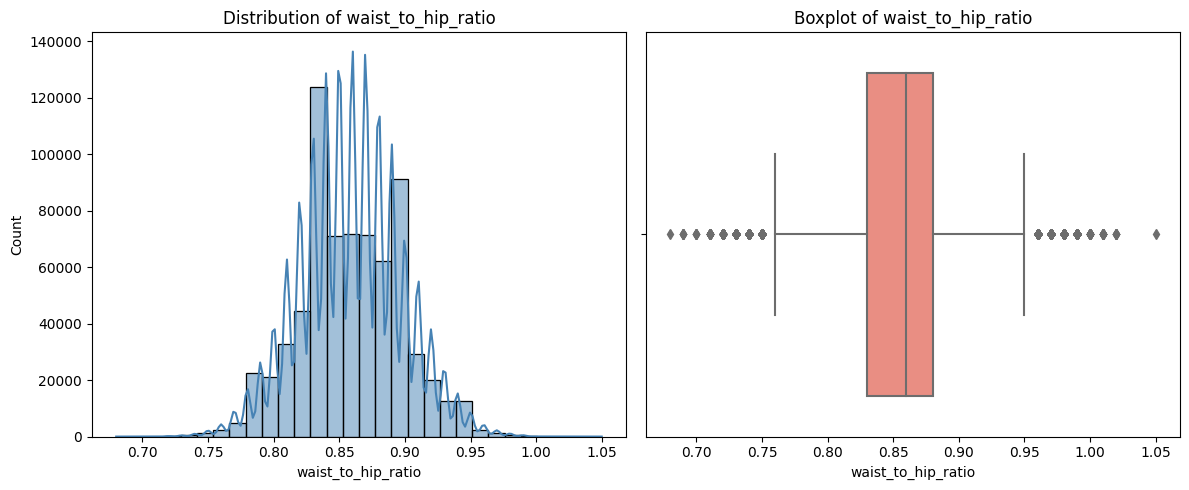

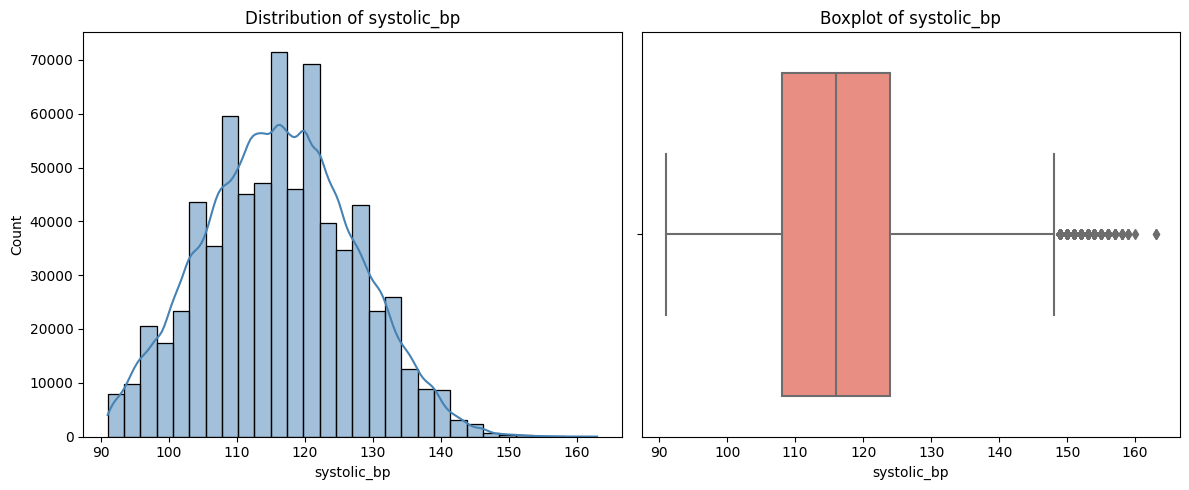

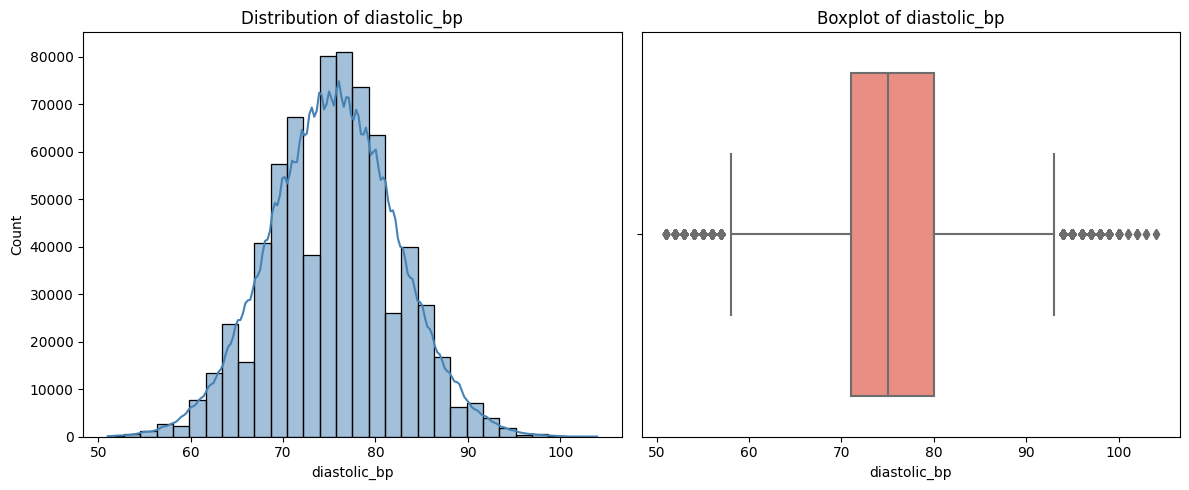

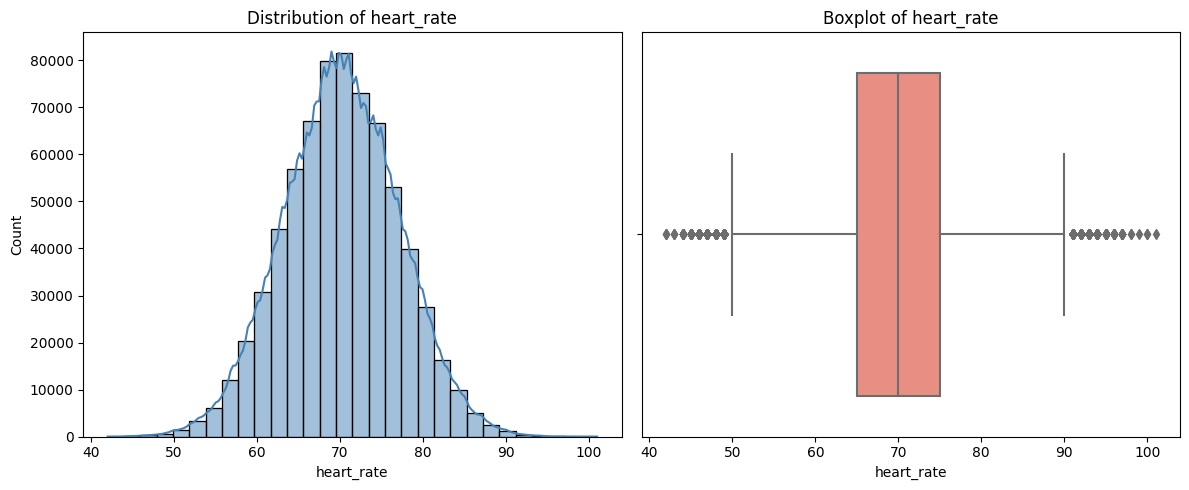

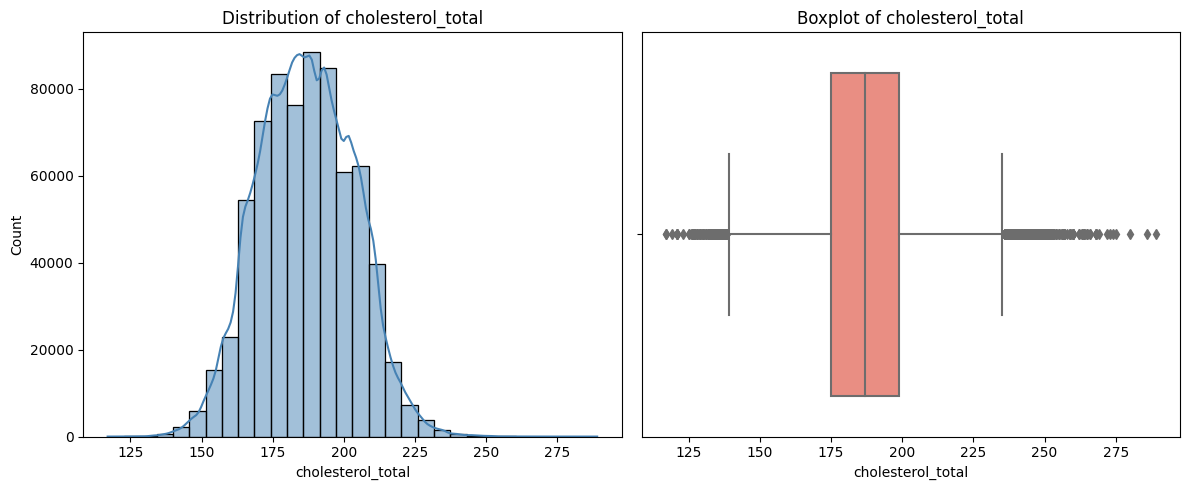

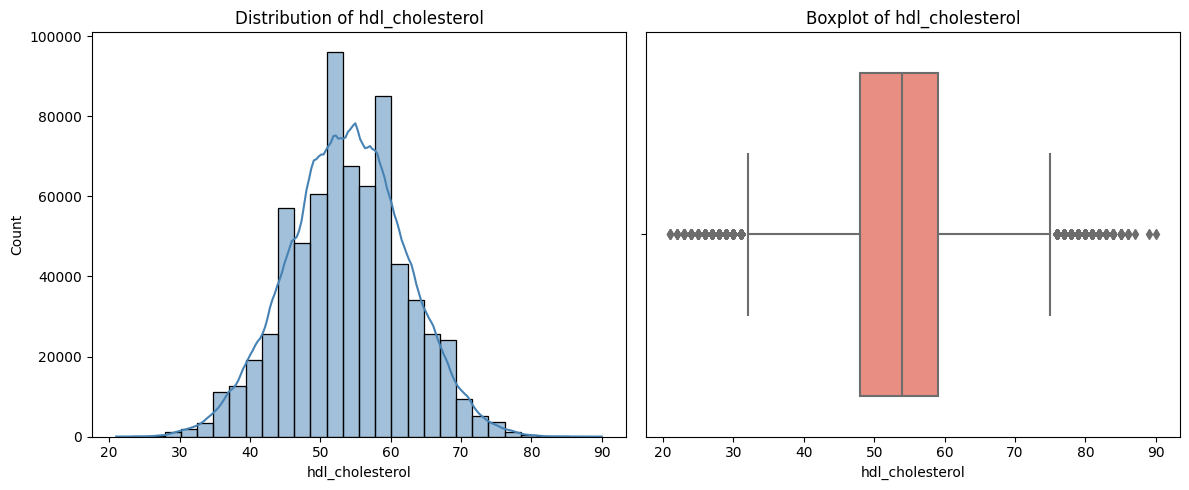

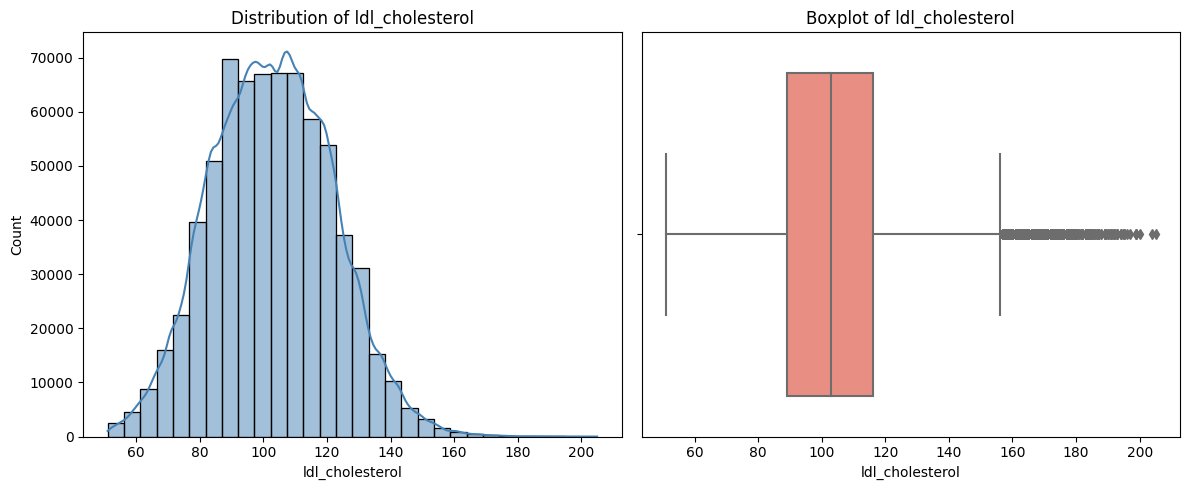

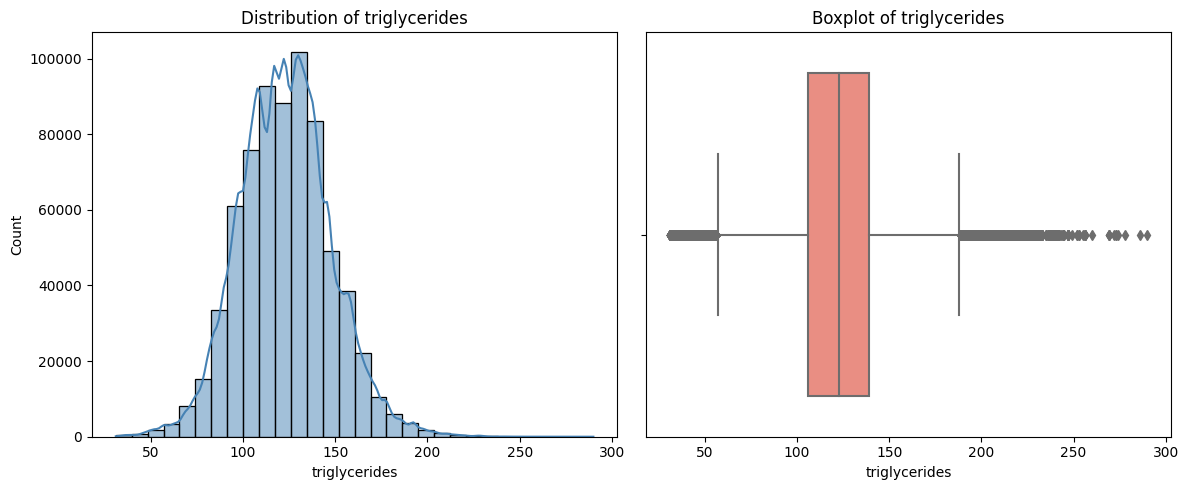

,variable,skewness,kurtosis,normality_p_value,insights
0,age,0.020905,-0.386746,0.000000e+00,Approximately symmetric distribution. | Reason...
1,alcohol_consumption_per_week,0.932373,0.704165,0.000000e+00,Moderate right-skew → may benefit from mild tr...
2,physical_activity_minutes_per_week,2.814191,13.196969,0.000000e+00,"Strong right-skew → long right tail, potential..."
3,diet_score,-0.062970,-0.161260,5.359503e-121,Approximately symmetric distribution. | Reason...
4,sleep_hours_per_day,0.001486,-0.059958,1.960590e-07,Approximately symmetric distribution. | Reason...
5,screen_time_hours_per_day,0.114109,-0.132795,6.995442e-209,Approximately symmetric distribution. | Reason...
6,bmi,0.032107,-0.022292,3.369130e-15,Approximately symmetric distribution. | Reason...
7,waist_to_hip_ratio,0.037715,0.011089,1.801486e-19,Approximately symmetric distribution. | Reason...
8,systolic_bp,0.097208,-0.393853,0.000000e+00,Approximately symmetric distribution. | Reason...
9,diastolic_bp,-0.001377,-0.037283,1.098048e-07,Approximately symmetric distribution. | Reason...


In [8]:
train_summary = analyze_numeric_distribution(train, NUMERIC_CONTINUOUS)
train_summary

## Numeric Features Correlation Heatmap

- Target (diagnosed_diabetes) has weak linear correlations with individual features (0.01–0.21)
- Strongest correlations are between features (Waist-hip ratio <-> BMI -> 0.76)


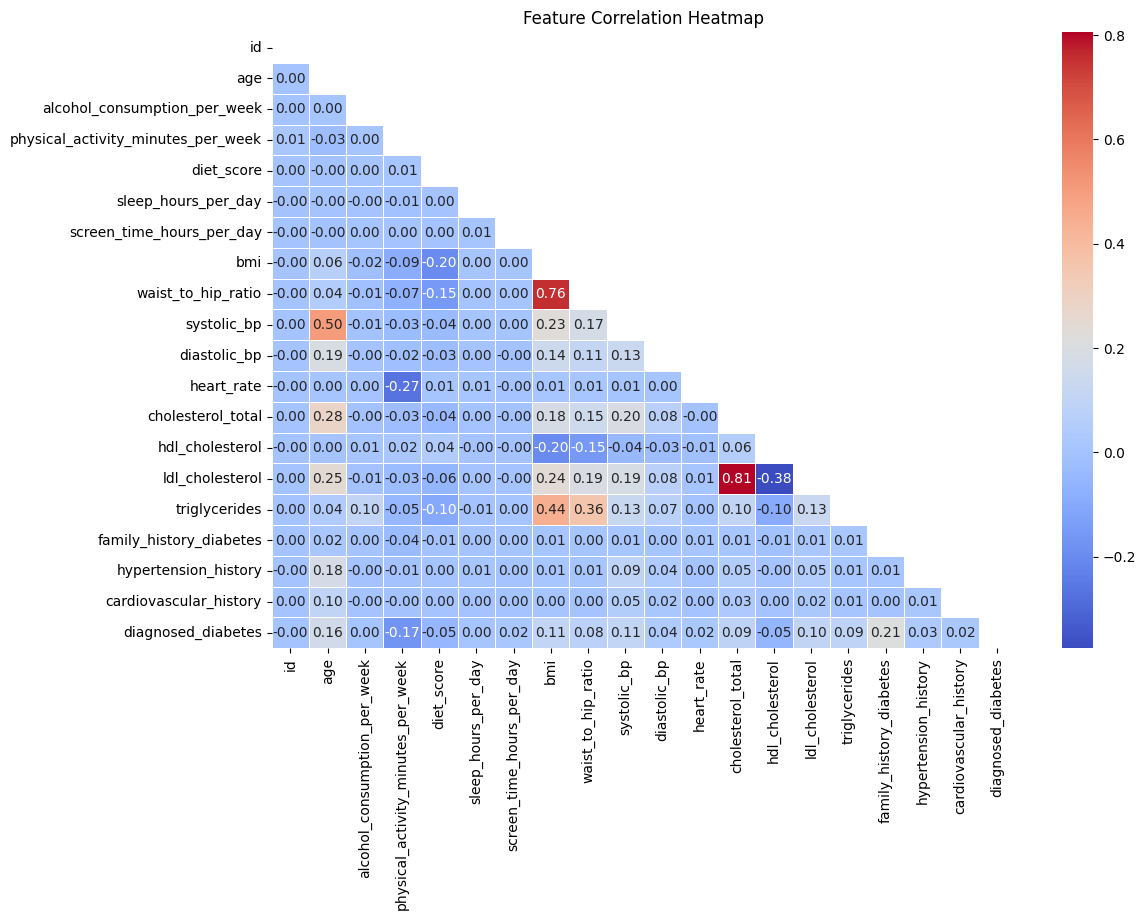

In [9]:
plot_correlation_matrix(train)

- Majority are non-smokers. “Current” and “Former” smokers each around 15%.
- Majority employed (74%)

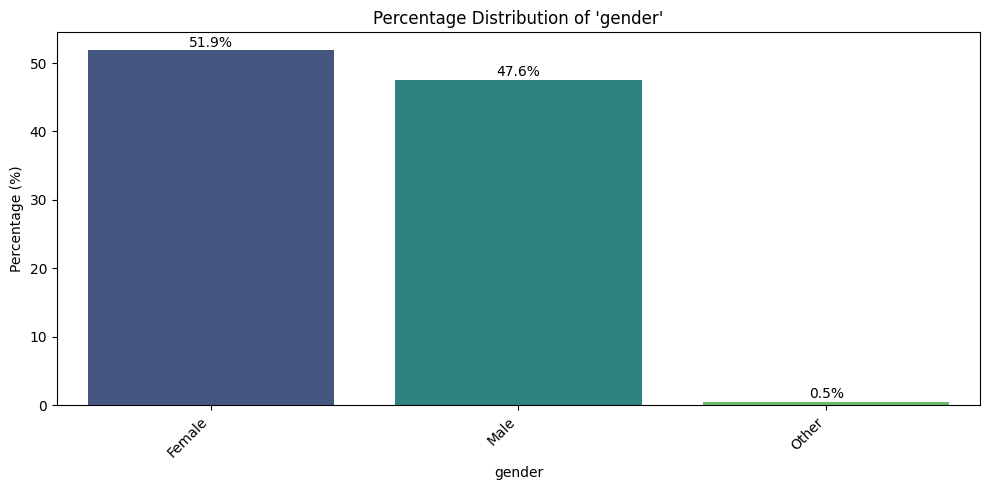

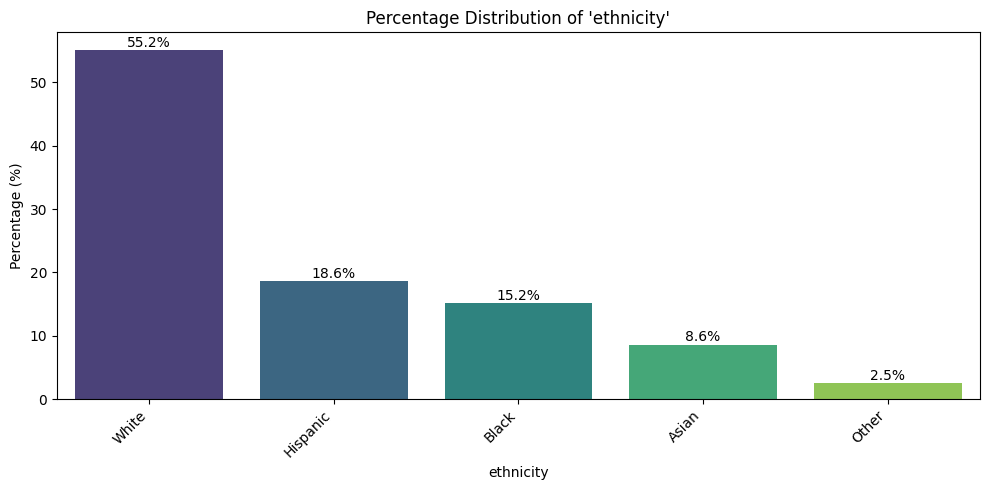

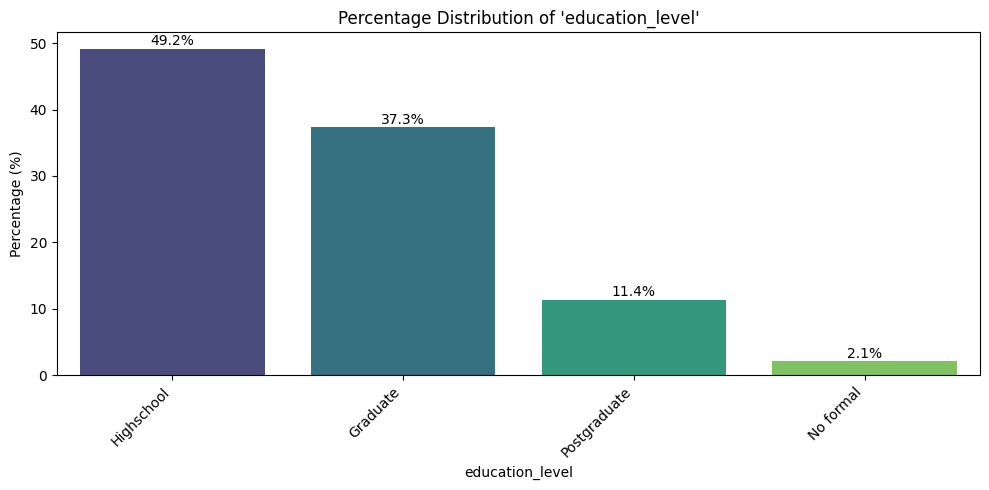

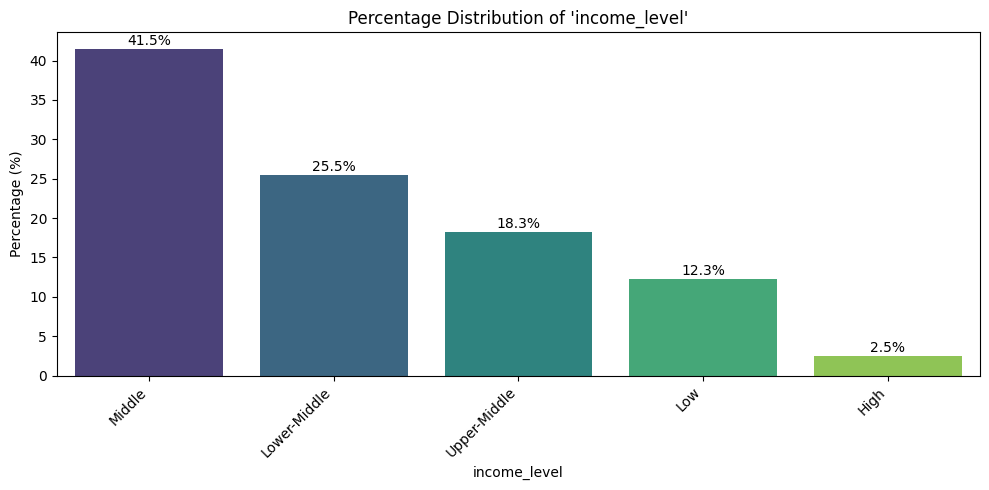

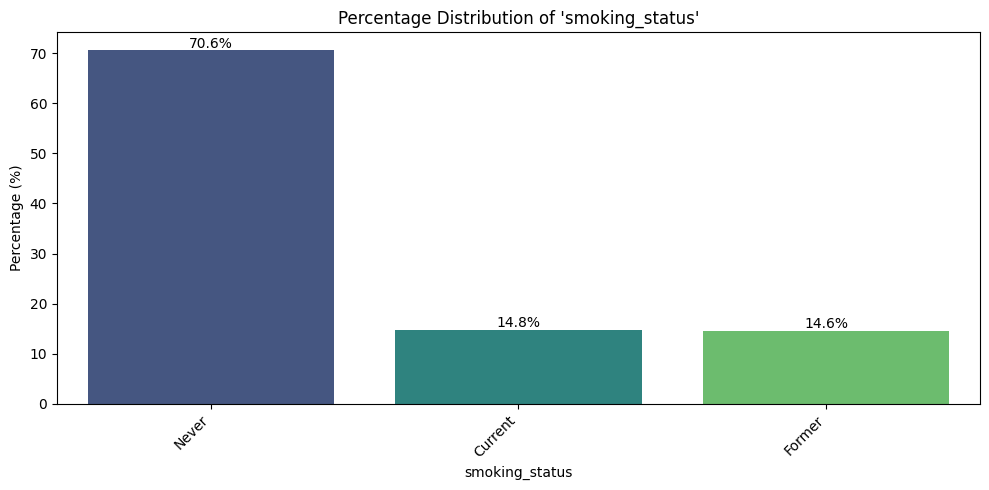

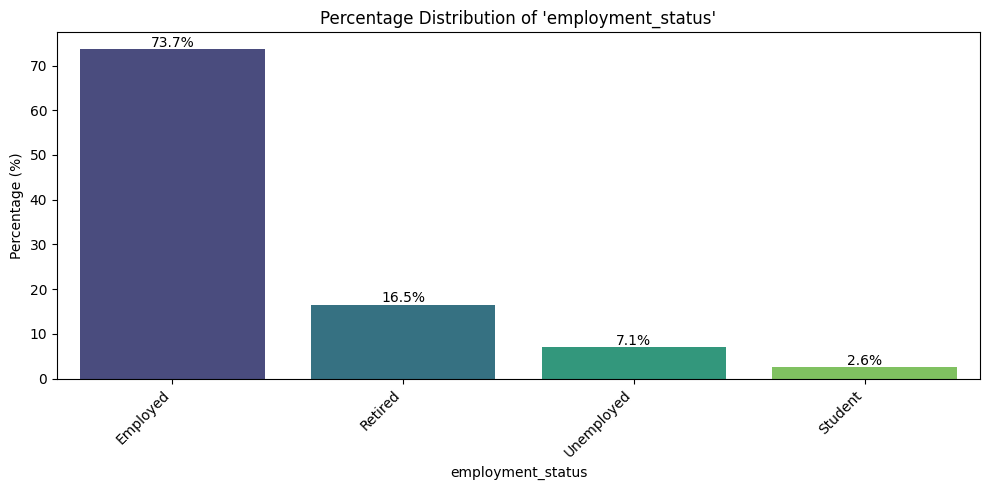

In [10]:
for col in CATEGORY_COLUMNS:
    plot_categorical_distribution(train, col)

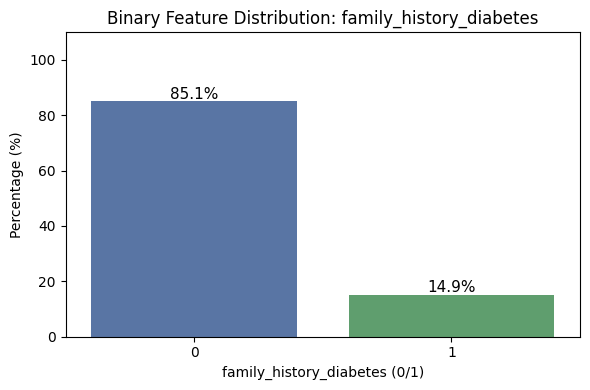

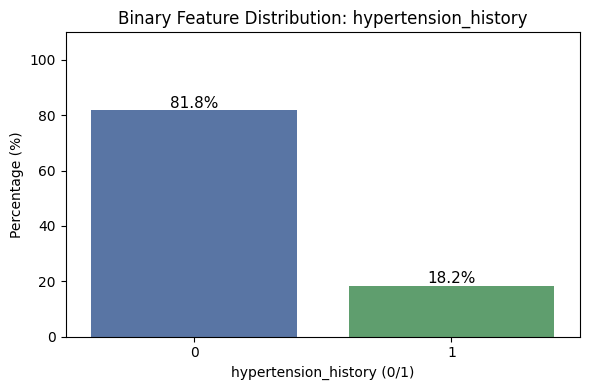

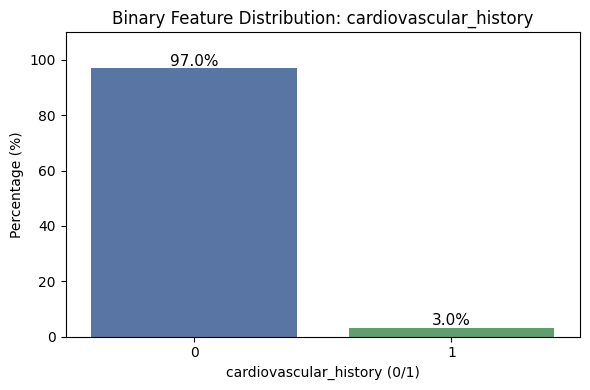

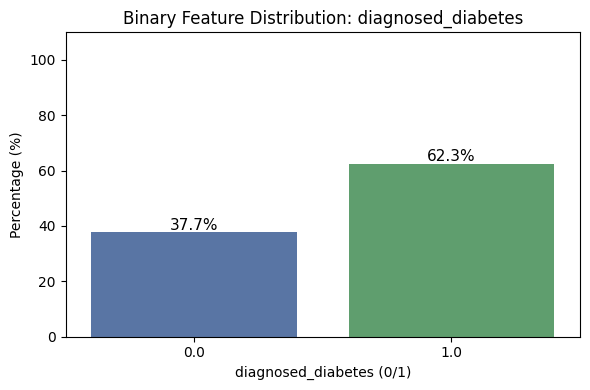

In [11]:
for col in [col for col in train.columns if train[col].dropna().nunique() == 2]:
    plot_binary_feature(train, col)


## Numeric Continuous Features vs Target

- Age is a strong risk factor, and this relationship is clearly visible.
- Diabetic individuals cluster more tightly at lower activity levels.
- Diabetics show a clear shift toward higher BMI values.
- Diabetics have higher waist-to-hip ratios.
- Diabetic individuals have higher systolic blood pressure on average.
- Diabetic individuals have a shift to slightly higher cholesterol levels.

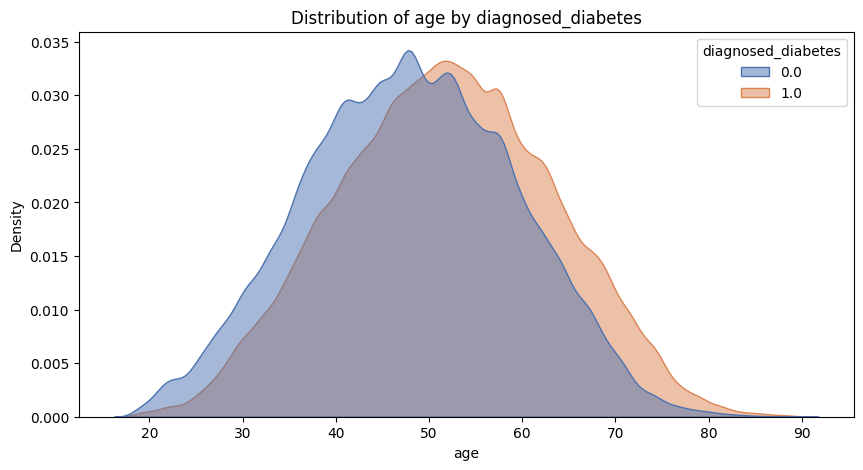

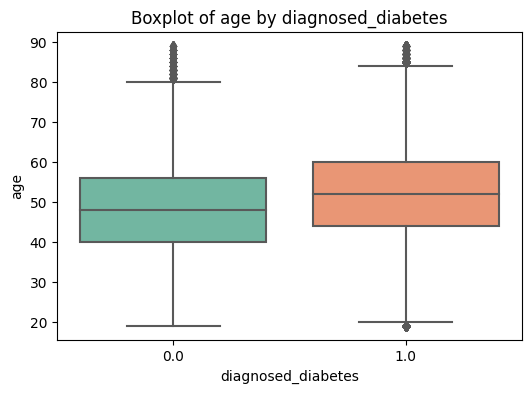


📌 **Stats for age vs diagnosed_diabetes:**
Mean (No Diabetes): 47.94
Mean (Diabetes):    51.82
Mean Difference:    3.88
Cohen's d:          0.338  → MEDIUM effect
T-test p-value:     0.000e+00



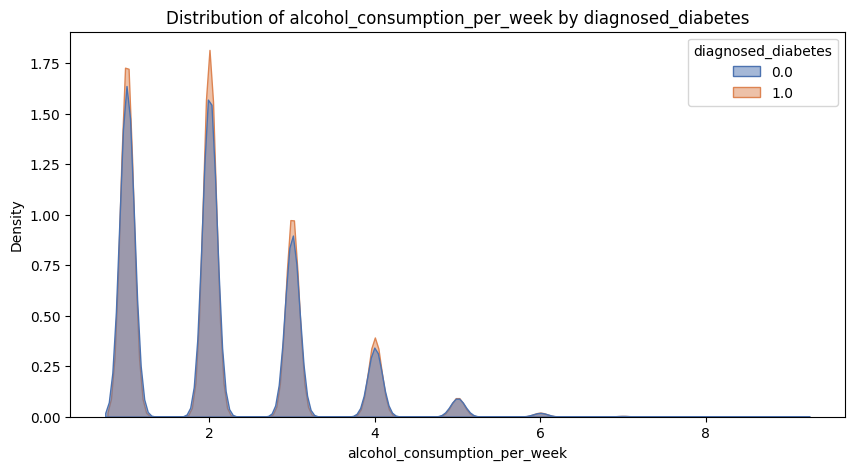

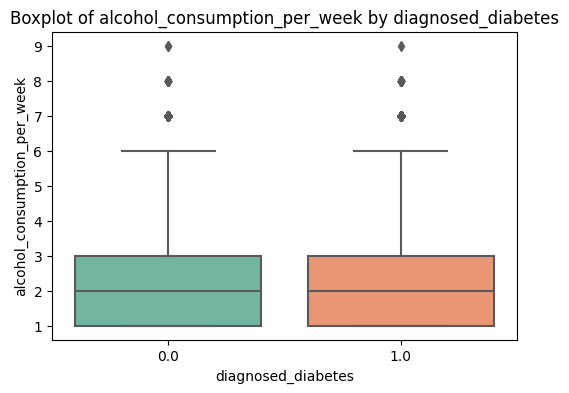


📌 **Stats for alcohol_consumption_per_week vs diagnosed_diabetes:**
Mean (No Diabetes): 2.07
Mean (Diabetes):    2.07
Mean Difference:    0.01
Cohen's d:          0.006  → SMALL effect
T-test p-value:     1.249e-02



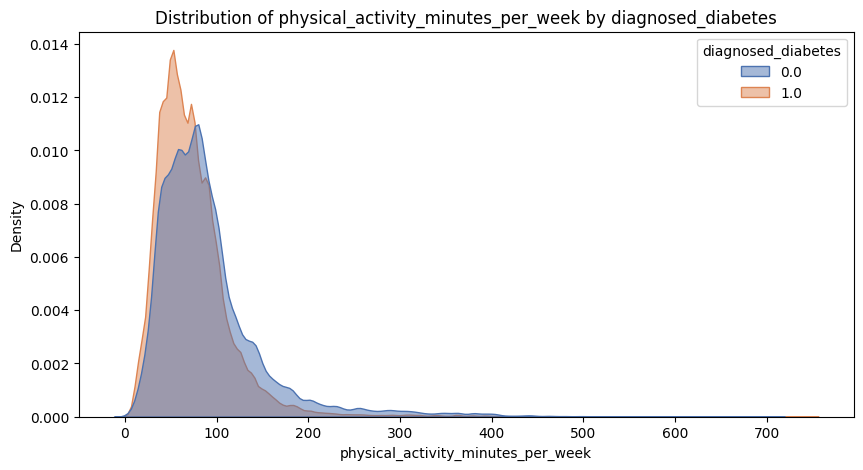

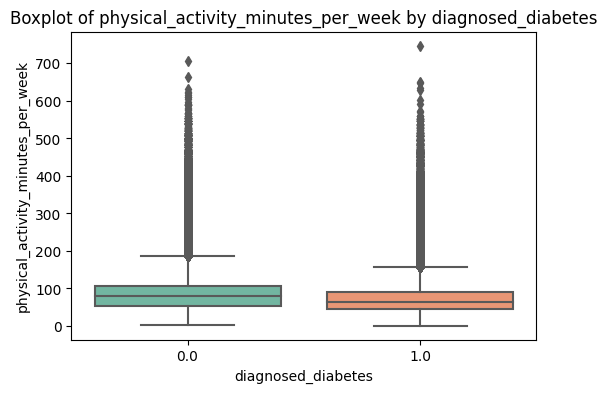


📌 **Stats for physical_activity_minutes_per_week vs diagnosed_diabetes:**
Mean (No Diabetes): 91.41
Mean (Diabetes):    73.47
Mean Difference:    -17.94
Cohen's d:          -0.341  → MEDIUM effect
T-test p-value:     0.000e+00



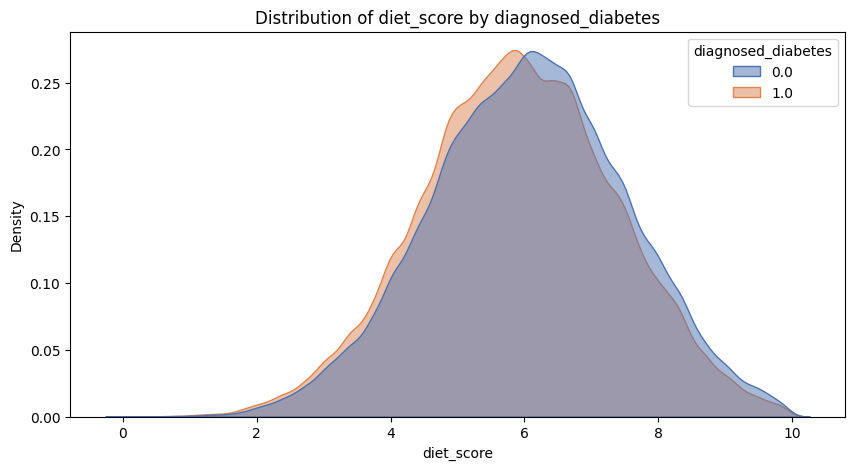

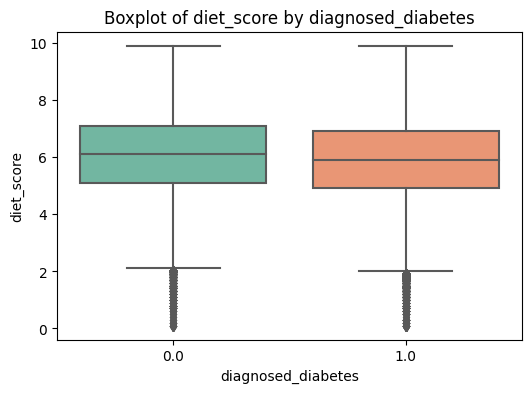


📌 **Stats for diet_score vs diagnosed_diabetes:**
Mean (No Diabetes): 6.06
Mean (Diabetes):    5.91
Mean Difference:    -0.15
Cohen's d:          -0.104  → SMALL effect
T-test p-value:     0.000e+00



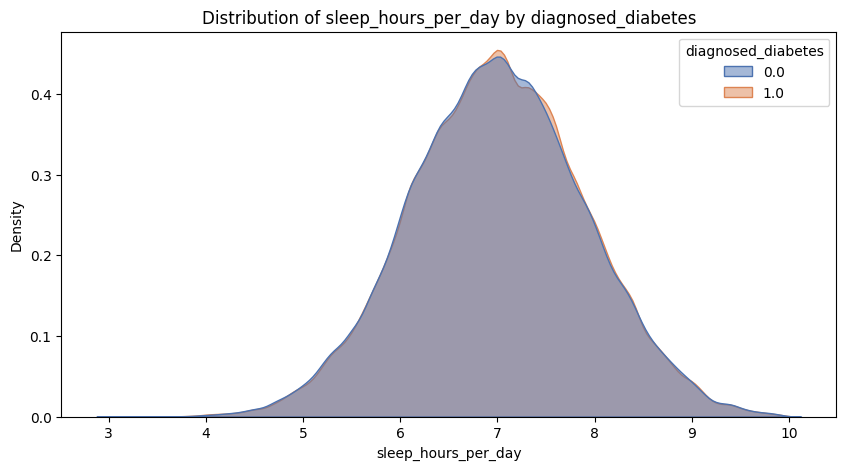

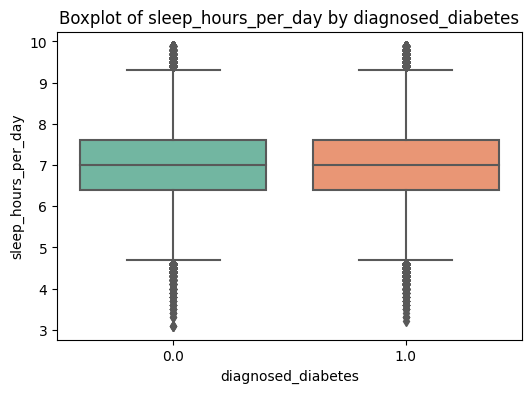


📌 **Stats for sleep_hours_per_day vs diagnosed_diabetes:**
Mean (No Diabetes): 7.00
Mean (Diabetes):    7.00
Mean Difference:    0.01
Cohen's d:          0.007  → SMALL effect
T-test p-value:     3.361e-03



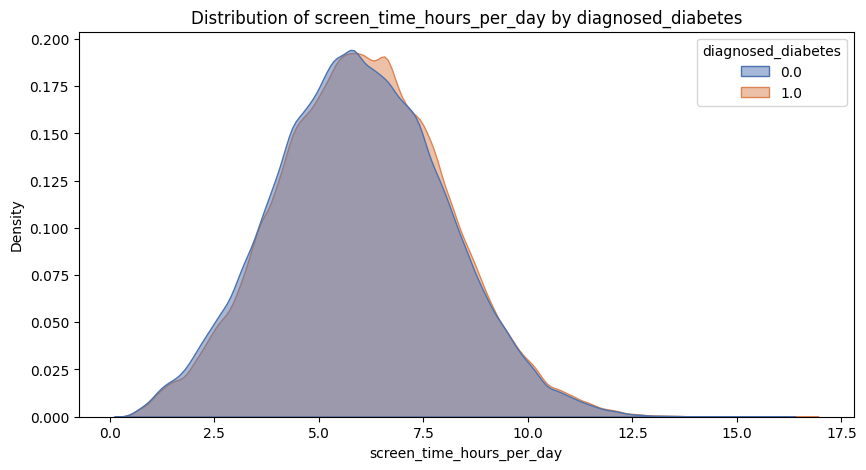

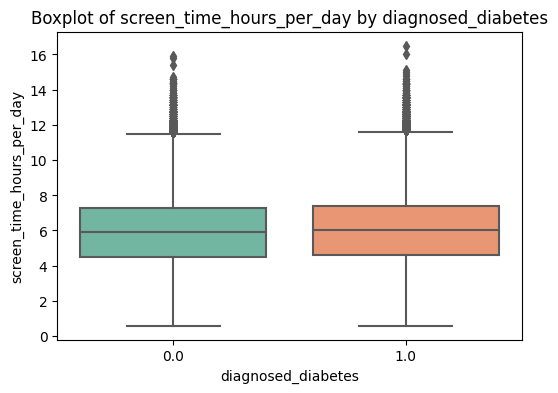


📌 **Stats for screen_time_hours_per_day vs diagnosed_diabetes:**
Mean (No Diabetes): 5.97
Mean (Diabetes):    6.04
Mean Difference:    0.08
Cohen's d:          0.038  → SMALL effect
T-test p-value:     2.434e-52



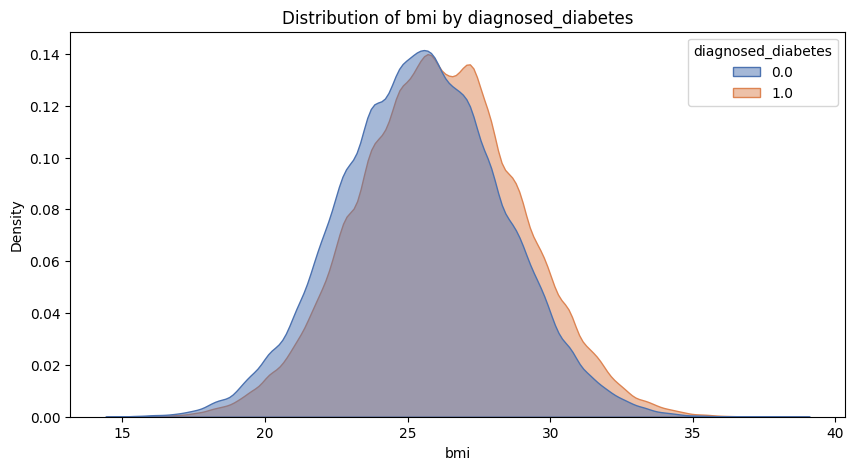

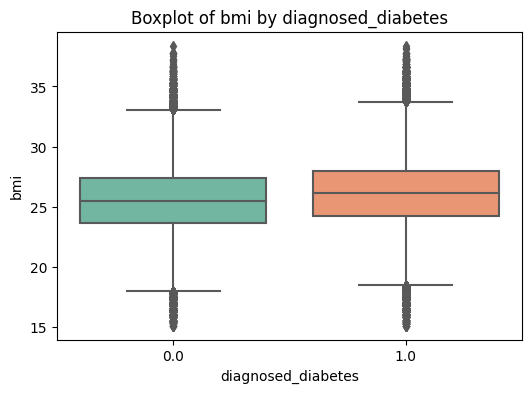


📌 **Stats for bmi vs diagnosed_diabetes:**
Mean (No Diabetes): 25.49
Mean (Diabetes):    26.11
Mean Difference:    0.62
Cohen's d:          0.219  → SMALL effect
T-test p-value:     0.000e+00



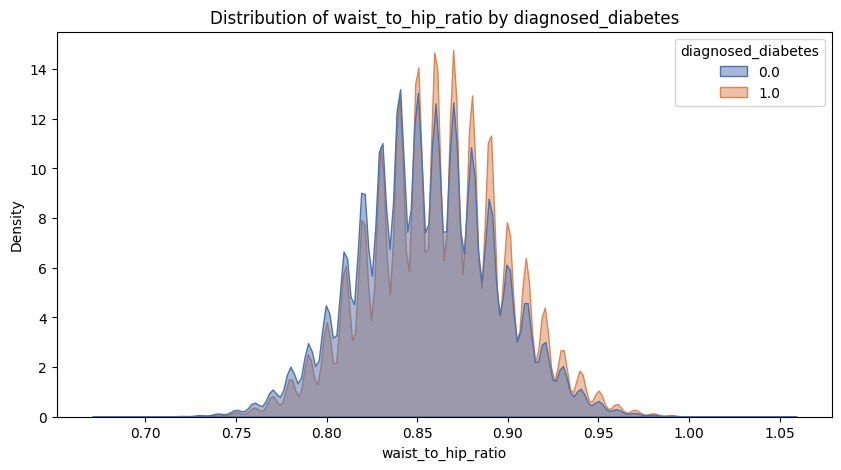

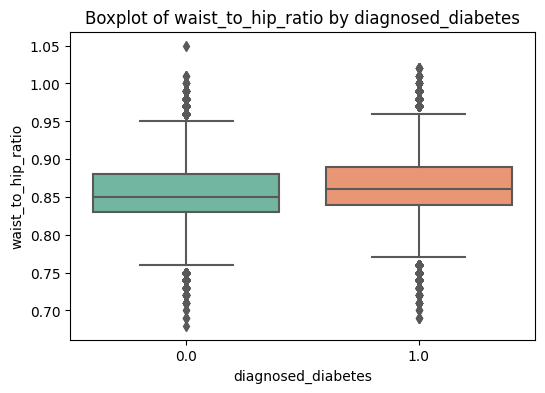


📌 **Stats for waist_to_hip_ratio vs diagnosed_diabetes:**
Mean (No Diabetes): 0.85
Mean (Diabetes):    0.86
Mean Difference:    0.01
Cohen's d:          0.168  → SMALL effect
T-test p-value:     0.000e+00



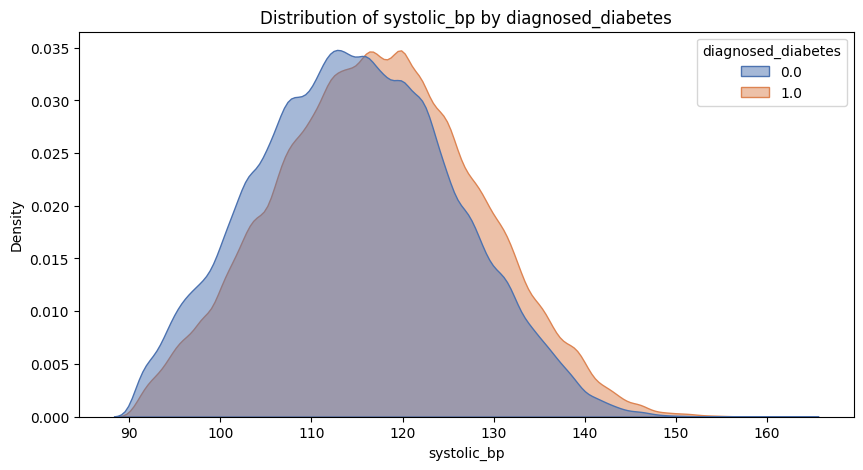

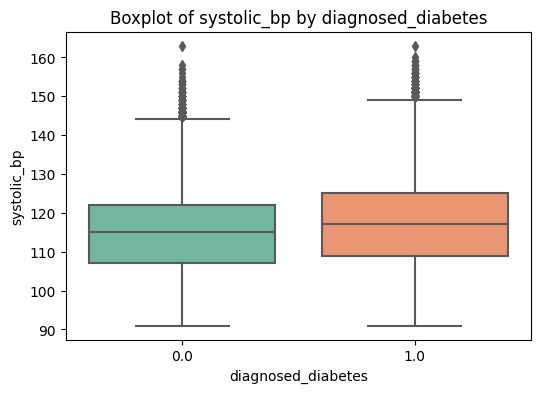


📌 **Stats for systolic_bp vs diagnosed_diabetes:**
Mean (No Diabetes): 114.78
Mean (Diabetes):    117.21
Mean Difference:    2.43
Cohen's d:          0.223  → SMALL effect
T-test p-value:     0.000e+00



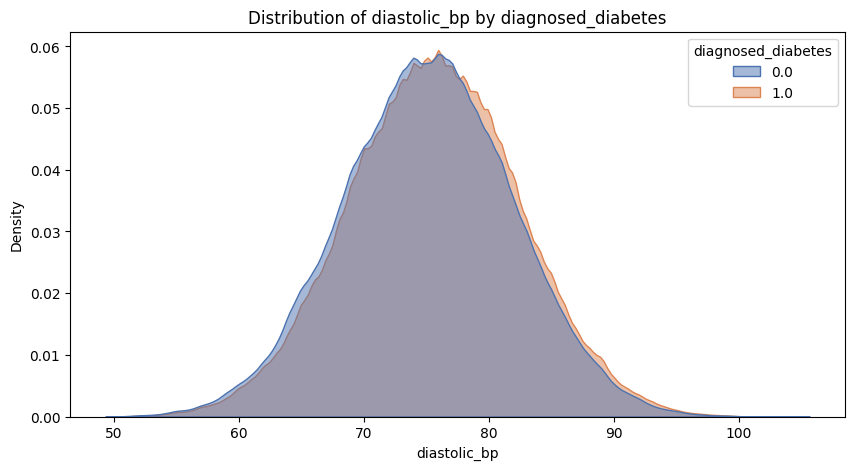

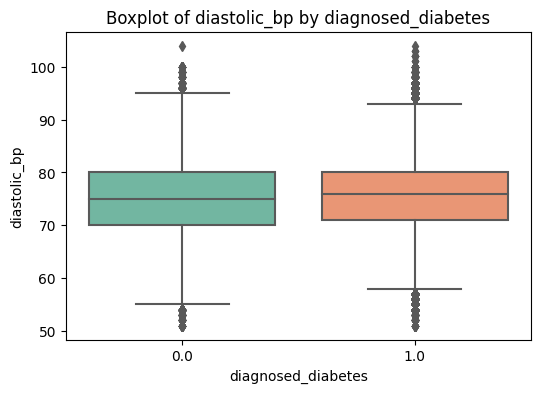


📌 **Stats for diastolic_bp vs diagnosed_diabetes:**
Mean (No Diabetes): 75.12
Mean (Diabetes):    75.63
Mean Difference:    0.51
Cohen's d:          0.075  → SMALL effect
T-test p-value:     2.316e-202



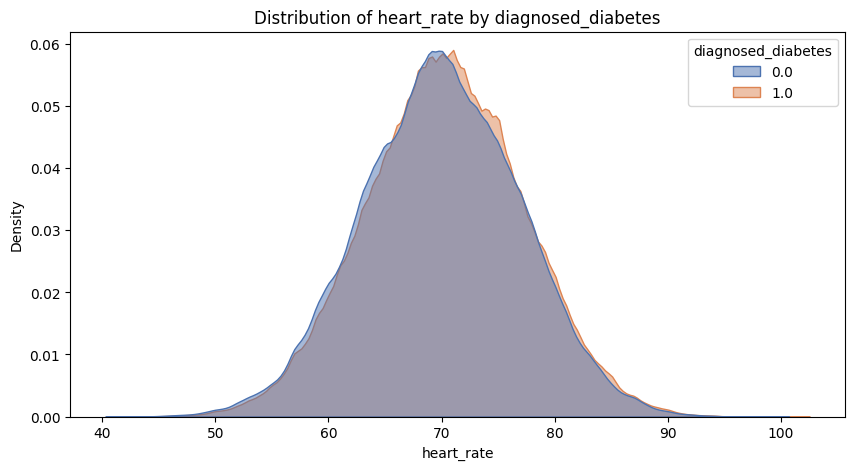

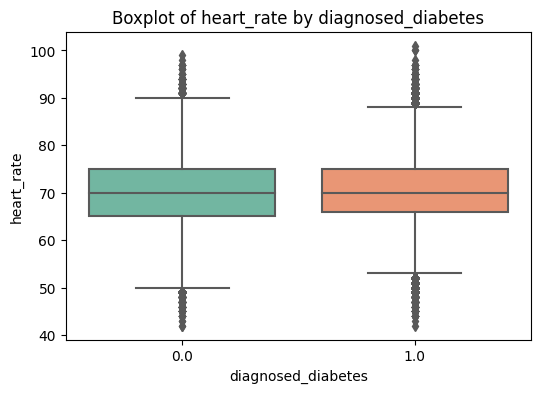


📌 **Stats for heart_rate vs diagnosed_diabetes:**
Mean (No Diabetes): 69.95
Mean (Diabetes):    70.30
Mean Difference:    0.34
Cohen's d:          0.049  → SMALL effect
T-test p-value:     2.157e-88



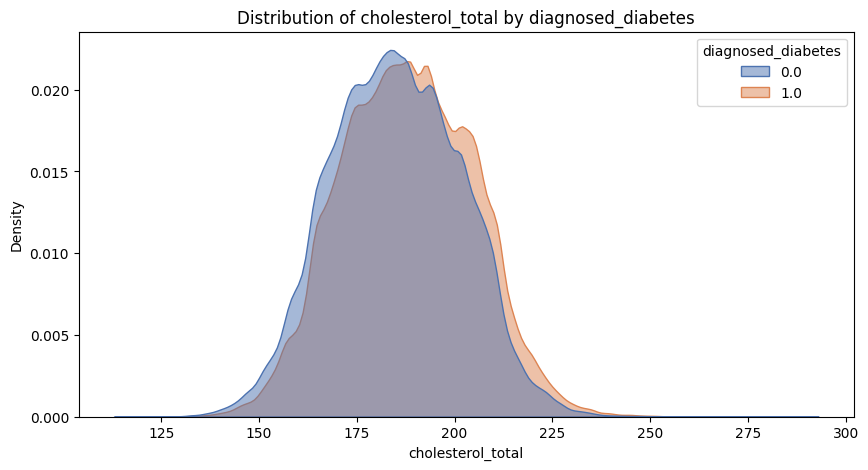

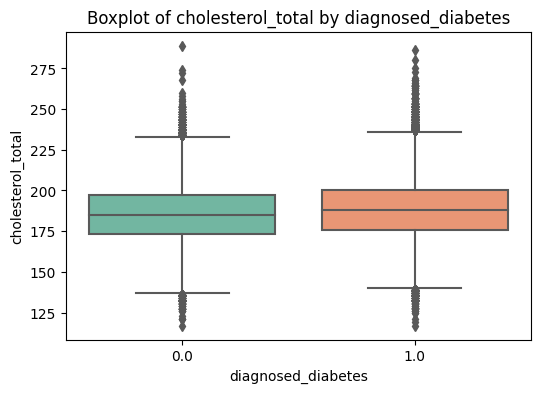


📌 **Stats for cholesterol_total vs diagnosed_diabetes:**
Mean (No Diabetes): 184.92
Mean (Diabetes):    187.96
Mean Difference:    3.04
Cohen's d:          0.183  → SMALL effect
T-test p-value:     0.000e+00



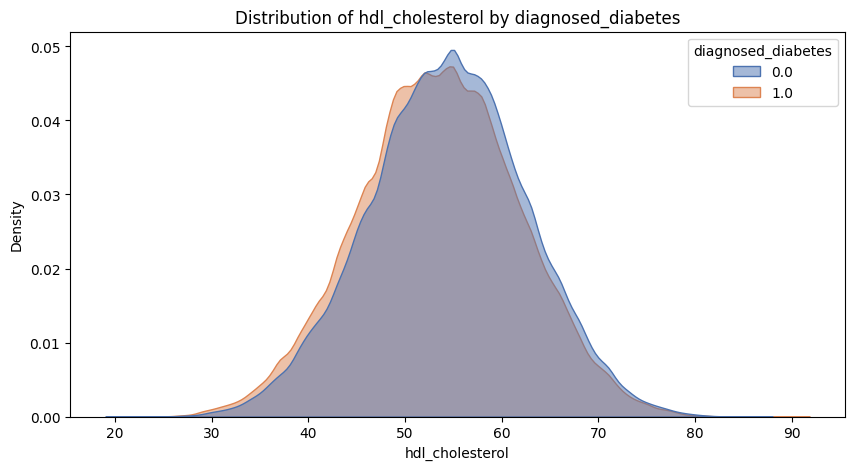

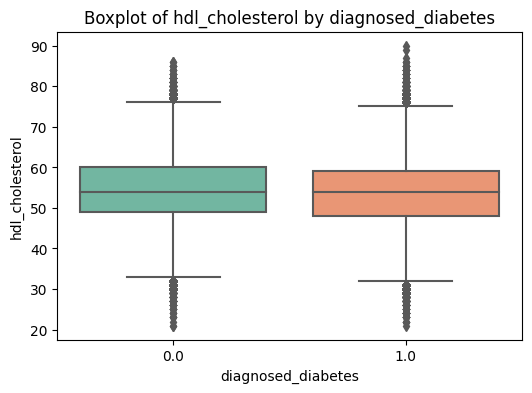


📌 **Stats for hdl_cholesterol vs diagnosed_diabetes:**
Mean (No Diabetes): 54.39
Mean (Diabetes):    53.48
Mean Difference:    -0.91
Cohen's d:          -0.110  → SMALL effect
T-test p-value:     0.000e+00



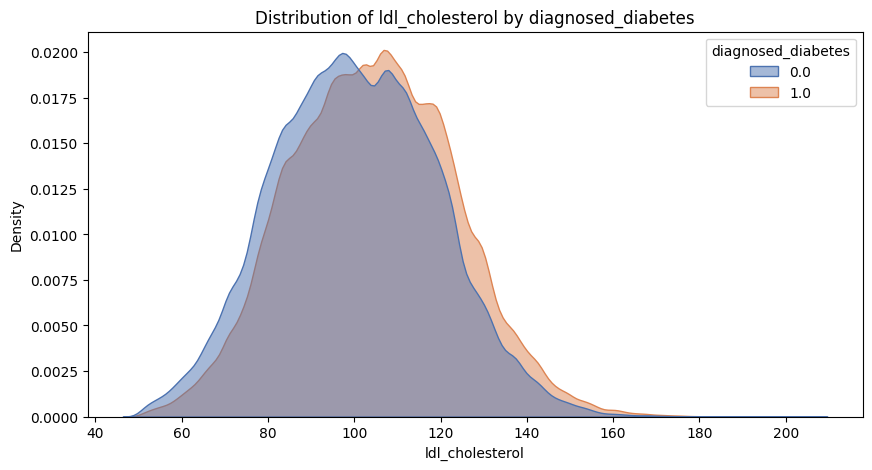

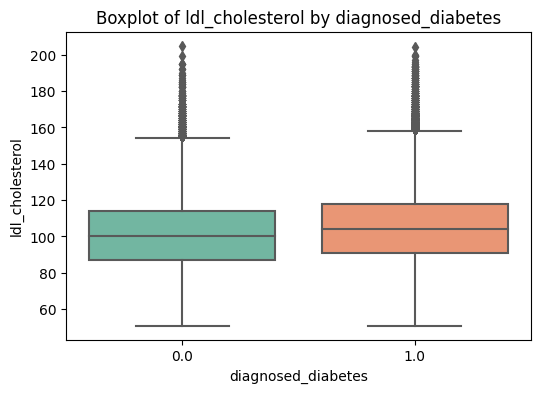


📌 **Stats for ldl_cholesterol vs diagnosed_diabetes:**
Mean (No Diabetes): 100.39
Mean (Diabetes):    104.43
Mean Difference:    4.03
Cohen's d:          0.213  → SMALL effect
T-test p-value:     0.000e+00



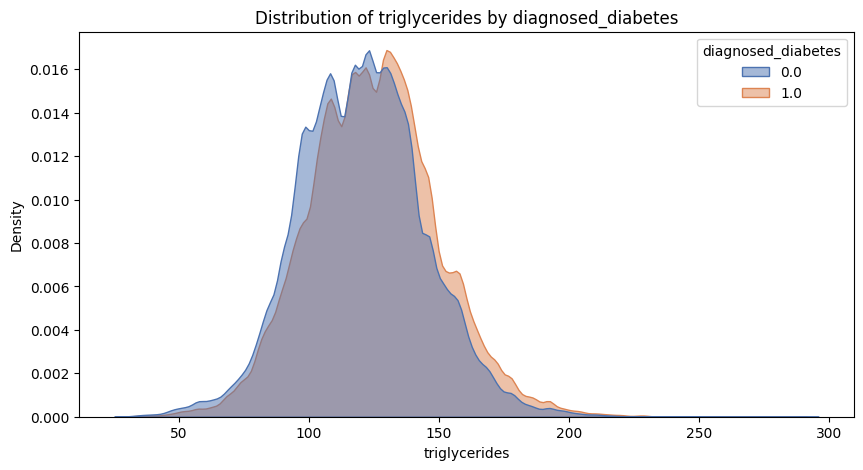

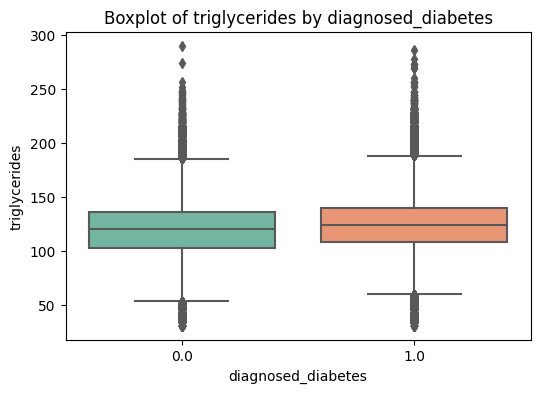


📌 **Stats for triglycerides vs diagnosed_diabetes:**
Mean (No Diabetes): 120.20
Mean (Diabetes):    124.83
Mean Difference:    4.63
Cohen's d:          0.188  → SMALL effect
T-test p-value:     0.000e+00



In [12]:
for col in NUMERIC_CONTINUOUS:
    numeric_vs_target(train, col, TARGET)


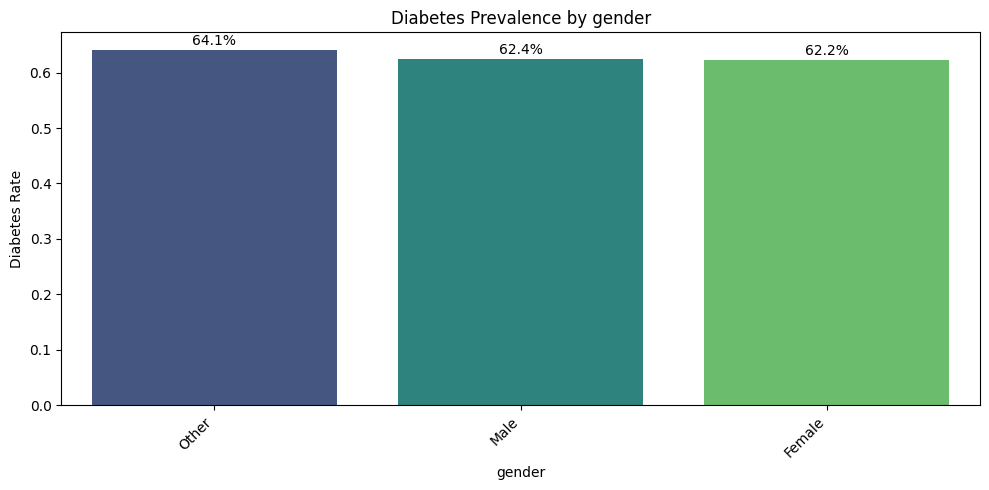

   gender  diagnosed_diabetes
0   Other            0.640566
1    Male            0.624294
2  Female            0.622205


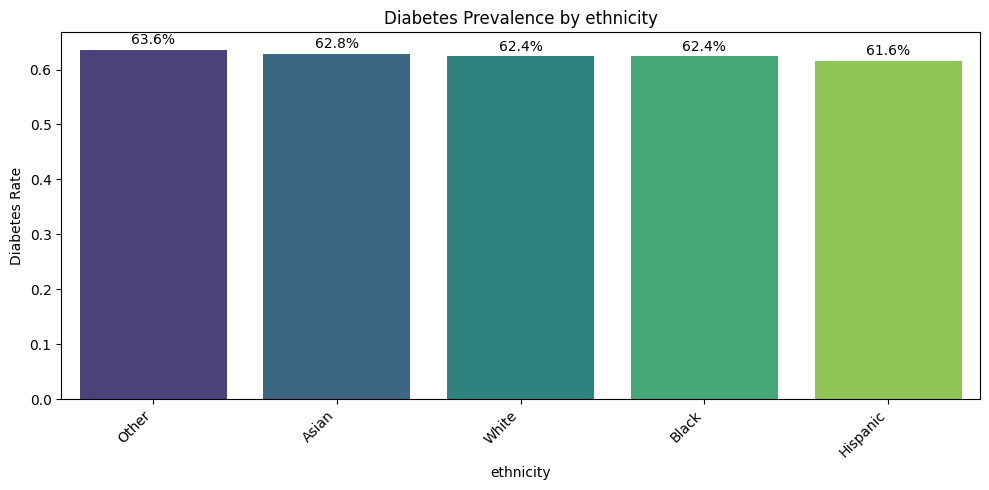

  ethnicity  diagnosed_diabetes
0     Other            0.635936
1     Asian            0.628493
2     White            0.624105
3     Black            0.623879
4  Hispanic            0.616314


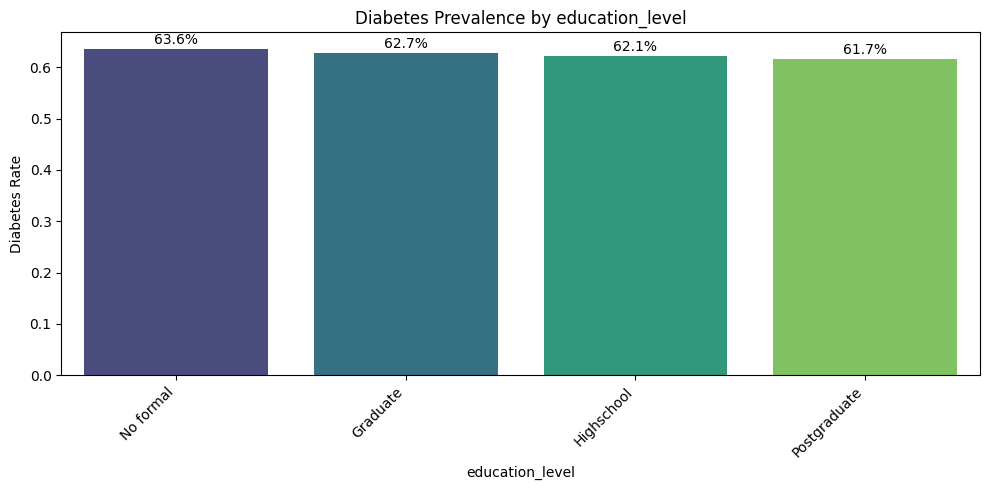

  education_level  diagnosed_diabetes
0       No formal            0.636066
1        Graduate            0.627008
2      Highschool            0.621462
3    Postgraduate            0.616647


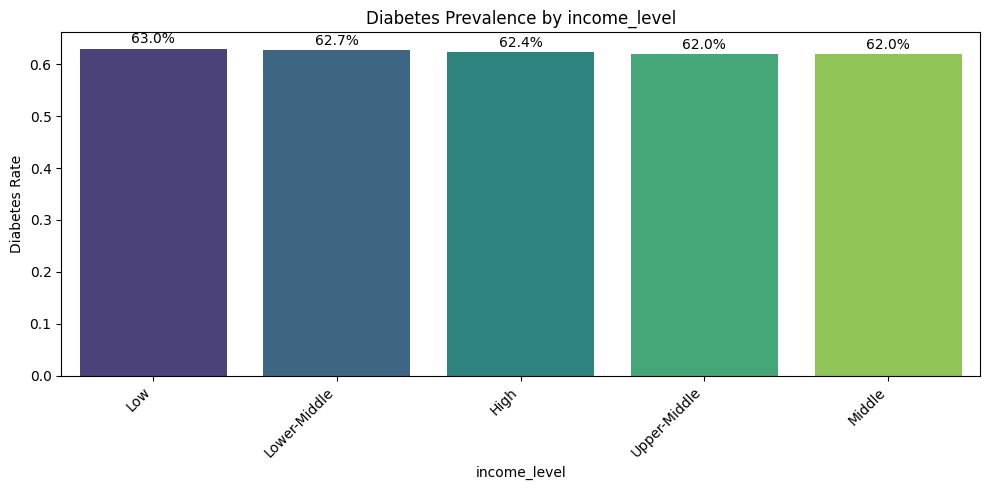

   income_level  diagnosed_diabetes
0           Low            0.630328
1  Lower-Middle            0.626835
2          High            0.623593
3  Upper-Middle            0.620420
4        Middle            0.620291


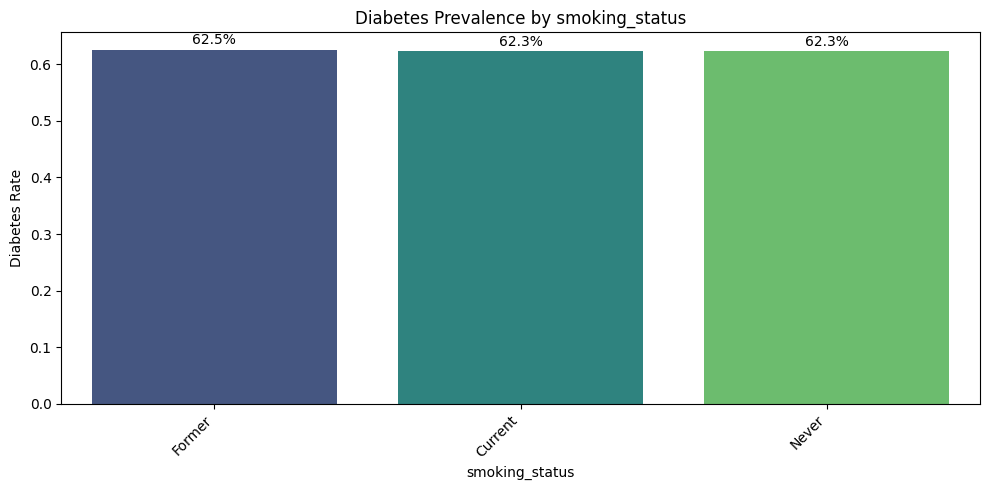

  smoking_status  diagnosed_diabetes
0         Former            0.625331
1        Current            0.623124
2          Never            0.622911


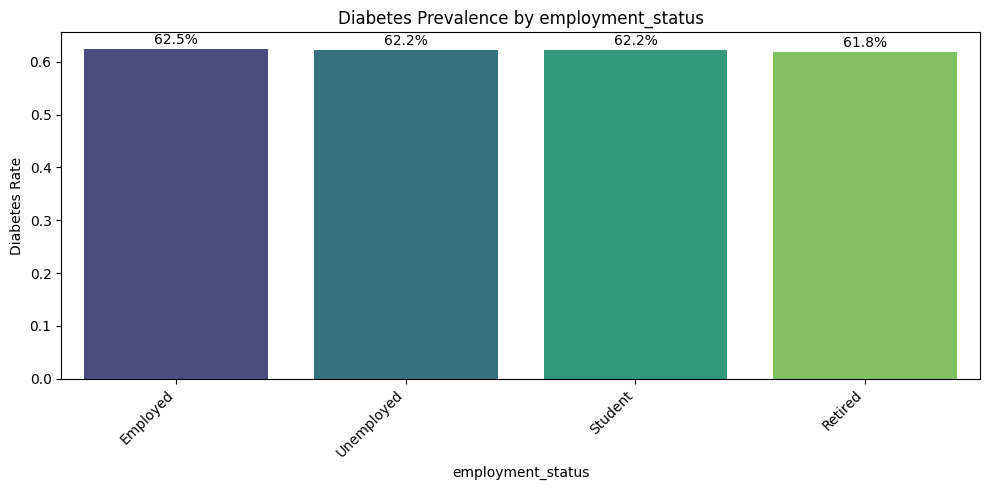

  employment_status  diagnosed_diabetes
0          Employed            0.624643
1        Unemployed            0.622130
2           Student            0.621586
3           Retired            0.618058


In [13]:
for col in CATEGORY_COLUMNS:
    categorical_vs_target(train, col, TARGET)

Genetic predisposition seems to be a strong predictor for target prediction.

Diabetes rate jumps from 58% → 87%

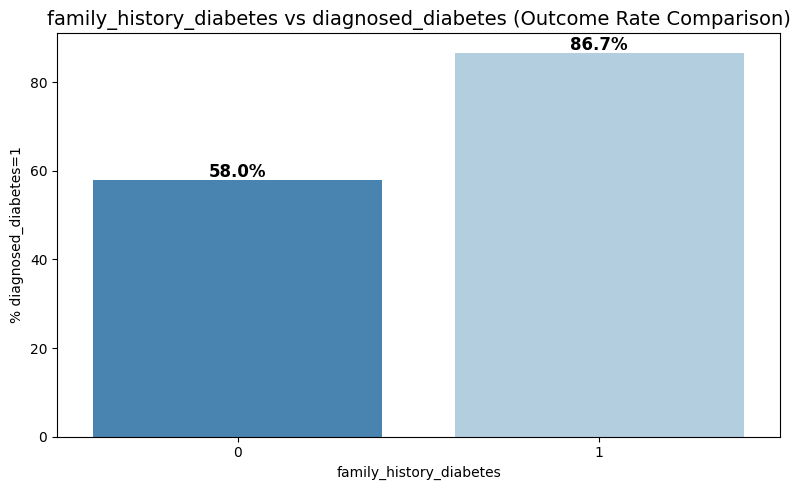

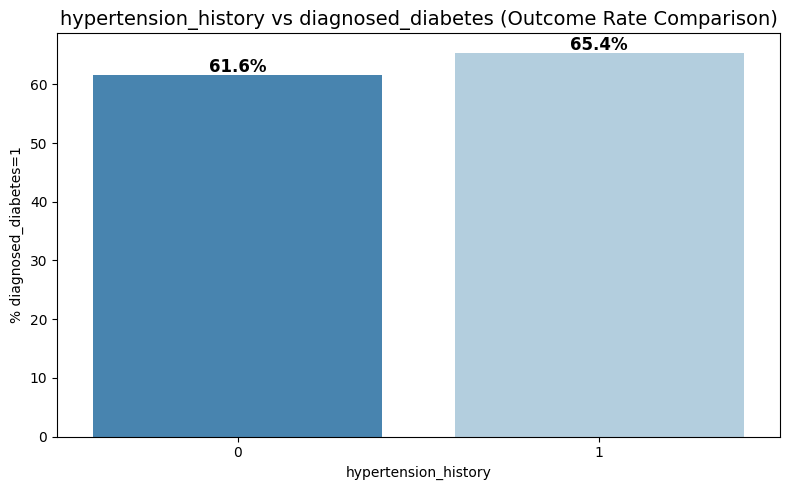

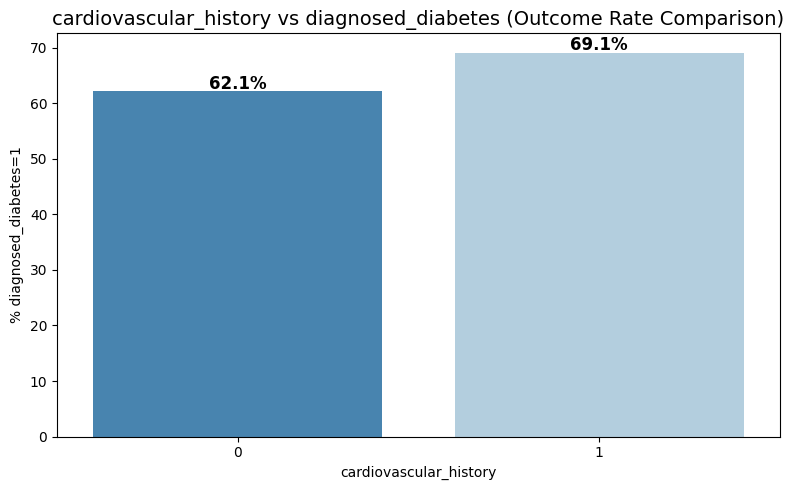

In [14]:
for col in NUMERIC_BINARY:
    binary_vs_target(train, col, TARGET)


## Model Training

In [15]:
train = engineer_features(train)
test = engineer_features(test)

for col in CATEGORY_COLUMNS:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")


===== LightGBM - Fold 1 =====
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 290871, number of negative: 175795
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6276
[LightGBM] [Info] Number of data points in the train set: 466666, number of used features: 45
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (17.80 MB) transferred to GPU in 0.019790 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623296 -> initscore=0.503561
[LightGBM] [Info] Start training from score 0.503561
[LightGBM] [Warning] Unknown parameter: eval_metric
Fold ROC-AUC: 0.7226

===== LightGBM - Fold 2 =====
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 290871, number of negative: 175796
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6277
[LightGBM] [Info] Number of data points in the train set: 466667, number of used features: 45
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU

Default metric period is 5 because AUC is/are not implemented for GPU


Fold ROC-AUC: 0.7237

===== CatBoost - Fold 2 =====


Default metric period is 5 because AUC is/are not implemented for GPU


Fold ROC-AUC: 0.7222

===== CatBoost - Fold 3 =====


Default metric period is 5 because AUC is/are not implemented for GPU


Fold ROC-AUC: 0.7227

===== CatBoost CV ROC-AUC: 0.7229 ± 0.0006 =====

===== LightGBM METRICS =====
ROC-AUC: 0.7222837040609019
F1: 0.7124402769181004
Precision: 0.7588348055850581
Recall: 0.6713919327446042


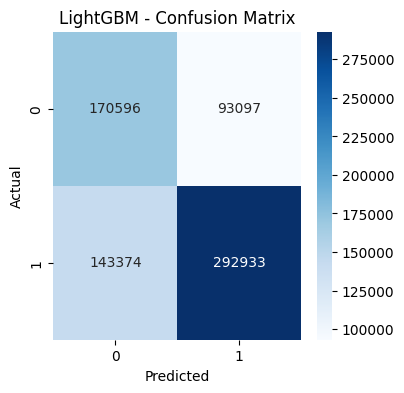

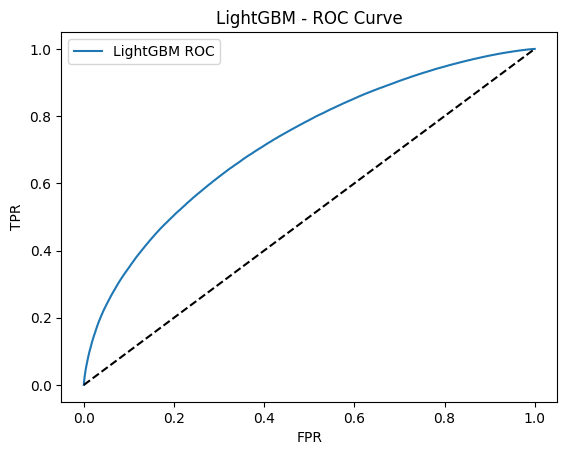

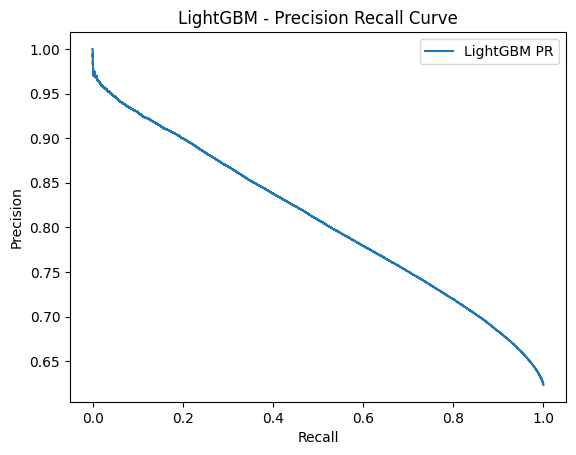


===== XGBoost METRICS =====
ROC-AUC: 0.7197310392838568
F1: 0.7140767638867399
Precision: 0.7554922919911908
Recall: 0.6769659895440596


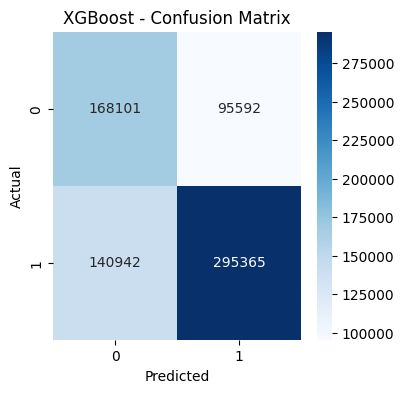

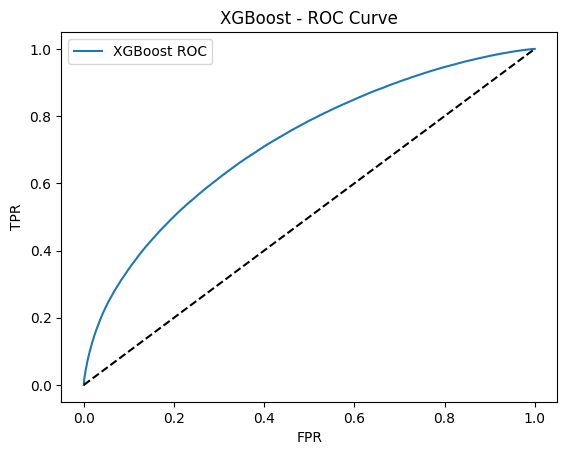

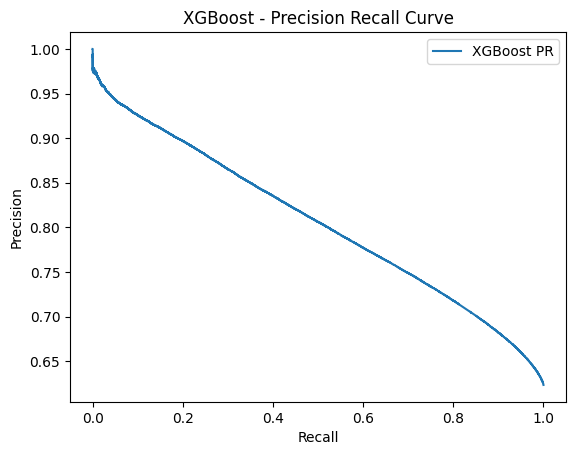


===== CatBoost METRICS =====
ROC-AUC: 0.7228790043140733
F1: 0.6961420344284018
Precision: 0.7701104385862527
Recall: 0.6351376439066987


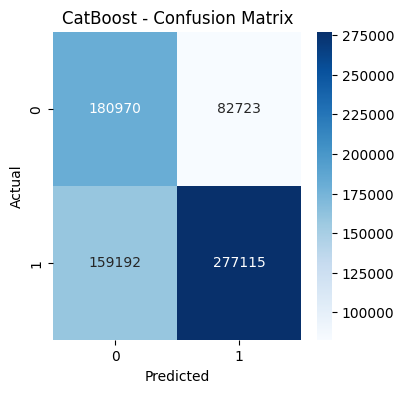

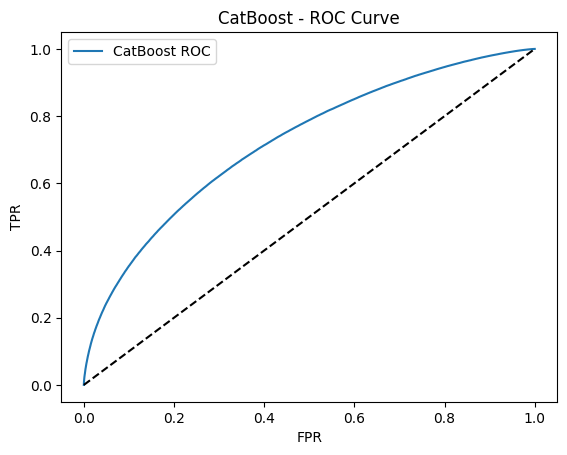

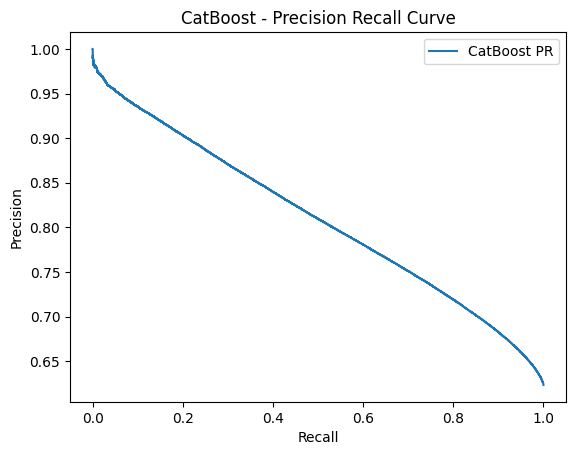


===== Ensemble METRICS =====
ROC-AUC: 0.724219629415898
F1: 0.6604706168152944
Precision: 0.7907440552288417
Recall: 0.5670502650656533


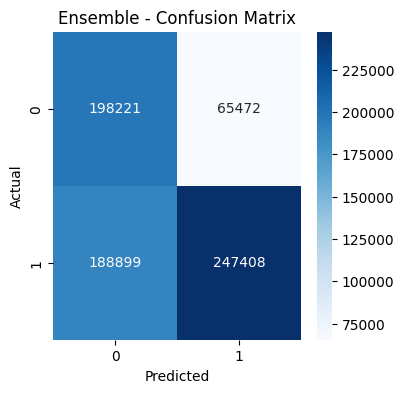

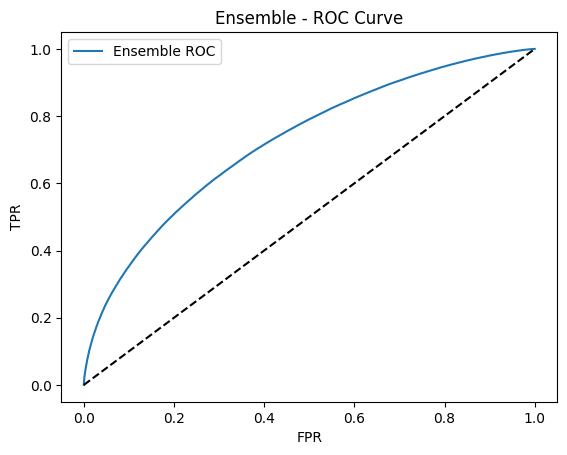

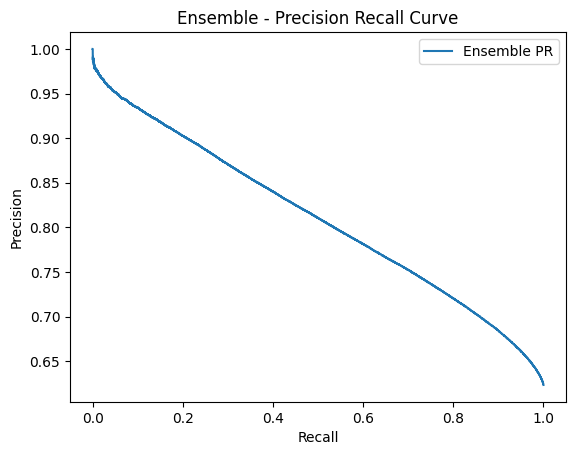

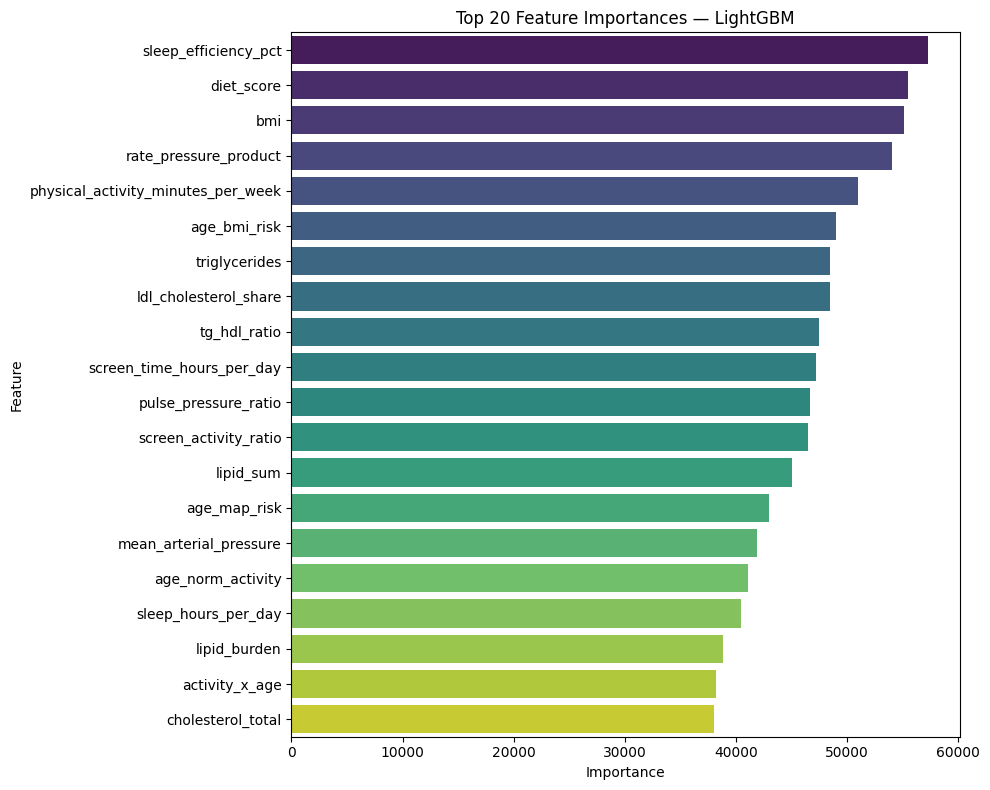

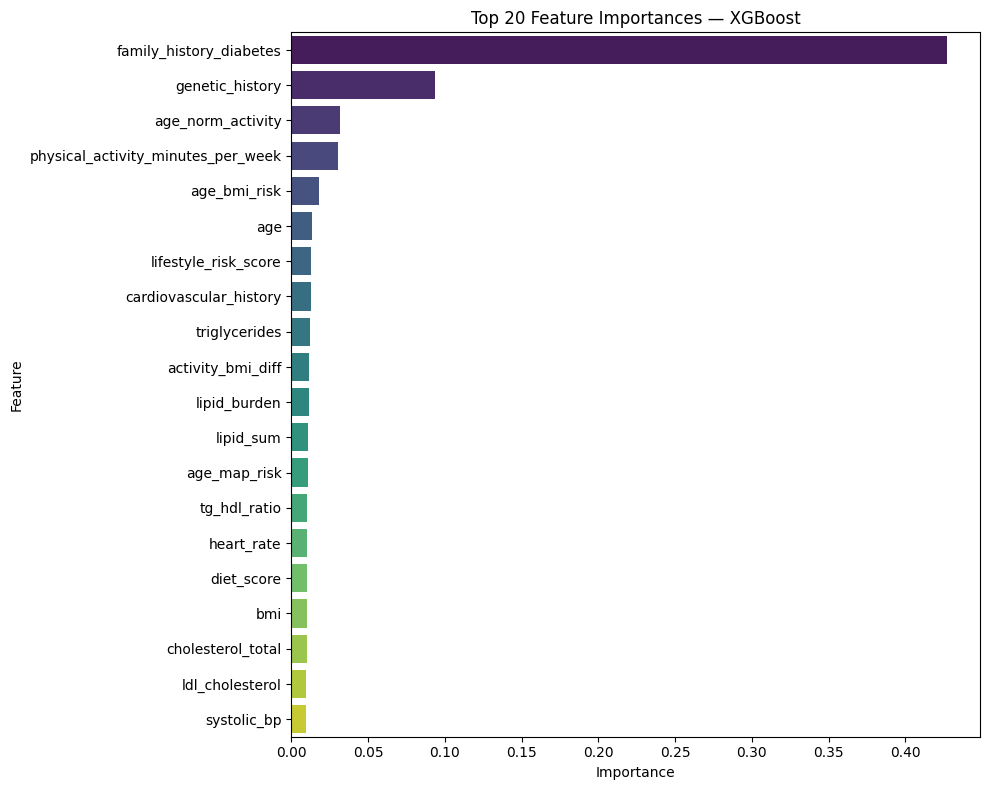

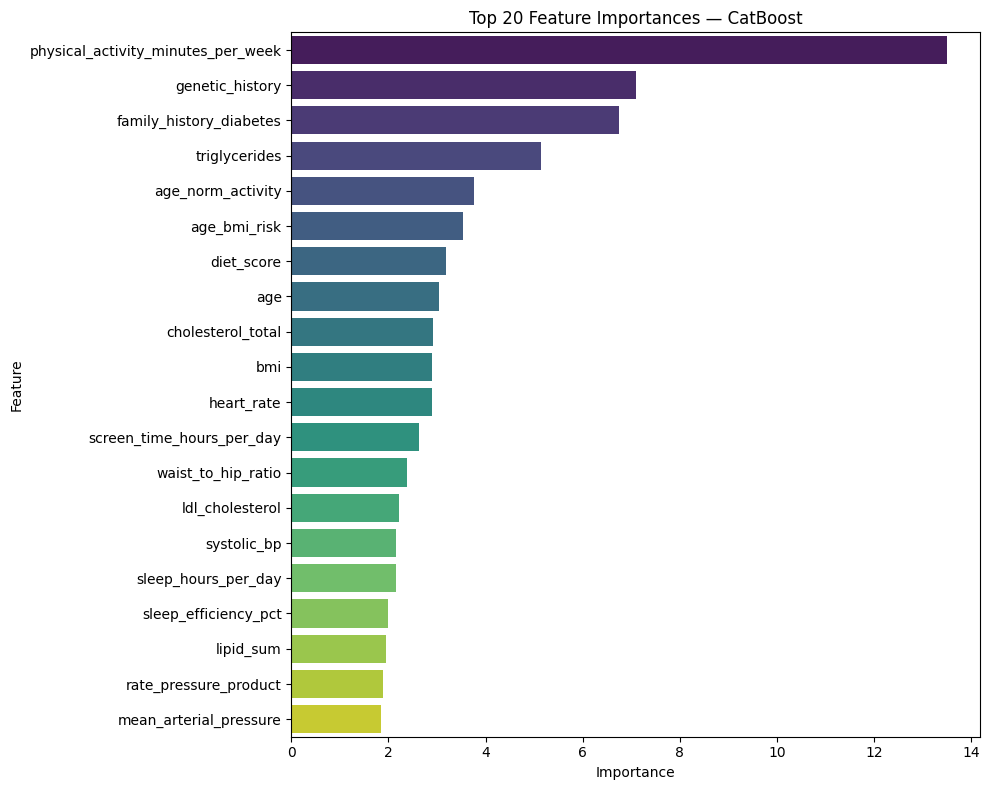

In [16]:
# Train Models
X = train.drop(columns=["diagnosed_diabetes"])
y = train["diagnosed_diabetes"]

oof_preds, models, fi_dict = train_all_models(X[MODEL_FEATURES], y)

# Evaluate each model
for name, preds in oof_preds.items():
    pred_labels = (preds >= 0.5).astype(int)
    evaluate_model(name, y, pred_labels, preds)

# Evaluate ensemble
evaluate_ensemble(oof_preds, y)

# Feature importance plots
for name, fi in fi_dict.items():
    plot_feature_importance(fi, name)

In [17]:
# Retrain models on full training data
full_models = fit_full_models(models, X[MODEL_FEATURES], y)

# Predict on test
test_preds_dict = predict_test(full_models, test[MODEL_FEATURES])

# Ensemble
test["diagnosed_diabetes"] = ensemble_predictions(test_preds_dict)


Training full model: LightGBM
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 436307, number of negative: 263693
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6272
[LightGBM] [Info] Number of data points in the train set: 700000, number of used features: 45
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (26.70 MB) transferred to GPU in 0.031142 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623296 -> initscore=0.503561
[LightGBM] [Info] Start training from score 0.503561

Training full model: XGBoost

Training full model: CatBoost


Default metric period is 5 because AUC is/are not implemented for GPU


[LightGBM] [Warning] Unknown parameter: eval_metric


In [18]:
submission = test[["id", "diagnosed_diabetes"]]
submission.to_csv("submission.csv", index=False)

submission.head()

,id,diagnosed_diabetes
0,700000,0.370879
1,700001,0.586585
2,700002,0.718963
3,700003,0.284591
4,700004,0.934417
